In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
import utils
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


random.seed(42)
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)
sc = StandardScaler()
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Análise Exploratória

In [2]:
df = pd.read_csv('winequality.csv', sep=';')
df.shape

(6497, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,9.000000


In [5]:
# Checando os valores unicos de density, pois o 3o quartil está próximo de 1 e o máximo é de 103.898
df.density.unique()

array([  1.001   ,   0.994   ,   0.9951  ,   0.9956  ,   0.9949  ,
         0.9938  ,   0.9908  ,   0.9947  ,   0.992   ,   0.9912  ,
        10.002   ,   0.9914  ,   0.9928  ,   0.9892  ,   0.9917  ,
         0.9955  ,   0.993   ,   0.9937  ,   0.9961  ,   0.9906  ,
         0.9974  ,   0.9934  ,   0.9939  ,   0.9962  ,   0.9905  ,
         0.9999  ,   0.9954  ,   0.9931  ,   0.995   ,   0.991   ,
         0.9911  ,   0.9972  ,   0.9926  ,   0.9927  ,   0.9903  ,
         0.9958  ,   0.9964  ,   0.9941  ,   0.9898  ,   0.9929  ,
         0.9985  ,   0.9946  ,   0.9966  ,   0.9975  ,   0.9957  ,
         0.99    ,   0.9899  ,   0.9916  ,   0.9969  ,   0.9979  ,
         0.9913  ,   0.997   ,   1.      ,   0.999   ,   0.9959  ,
         0.9982  ,   0.9968  ,   0.9984  ,   0.9952  ,   0.9924  ,
         0.9923  ,   0.9921  ,   0.9918  ,   0.9919  ,   0.9894  ,
         0.998   ,   0.9932  ,   0.9896  ,   0.9902  ,   0.9936  ,
         0.9942  ,   0.9973  ,   0.9944  ,   0.9989  ,   0.997

In [6]:
#Ajustando a variável density, pois possuem valores não compatíveis com a densidade de um vinho (Próximo de 1)
df['density'] = df['density'].apply(utils.adjusting_density)

In [7]:
# Checando os valores unicos de alcohol, pois aparentemente é uma variável float, mas foi importada como object
df.alcohol.unique()

array(['8.8', '9.5', '10.1', '9.9', '9.6', '11', '12', '9.7', '10.8',
       '12.4', '11.4', '12.8', '11.3', '10.5', '9.3', '10', '10.4',
       '11.6', '12.3', '10.2', '9', '11.2', '8.6', '9.4', '9.8', '11.7',
       '10.9', '9.1', '8.9', '10.3', '12.6', '10.7', '12.7', '10.6',
       '9.2', '8.7', '11.5', '11.8', '12.1', '11.1', '8.5', '12.5',
       '11.9', '12.2', '12.9', '13.9', '14', '13.5', '13.3', '13.2',
       '13.7', '13.4', '13', '8', '13.1', '8.0', '13.6', '8.4', '14.2',
       '11.94', '128.933.333.333.333', '114.666.666.666.667', '10.98',
       '100.333.333.333.333', '114.333.333.333.333',
       '105.333.333.333.333', '953.333.333.333.333',
       '109.333.333.333.333', '113.666.666.666.667',
       '113.333.333.333.333', '110.666.666.666.667',
       '973.333.333.333.333', '11.05', '9.75', '11.35', '9.55', '10.55',
       '11.45', '14.05', '123.333.333.333.333', '12.75', '13.8', '12.15',
       '13.05', '112.666.666.666.667', '105.666.666.666.667',
       '117.333.333

In [8]:
# Ajustando a variável alcohol, pois possui entradas não compatíveis com a concentração de alcool de um vinho
df['alcohol'] = df['alcohol'].apply(utils.filtering_alcohol)

In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491798,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192710,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [10]:
def quality_level(quality):
    if quality <= 4:
        return 'Bad'
    elif quality in (5, 6):
        return 'Medium'
    elif quality >= 7:
        return 'Good'
df['quality_level'] = df['quality'].apply(quality_level)

In [11]:
cat_cols = ['type', 'quality_level']
for col in cat_cols:
    print('Value Count for', col)
    print(df[col].value_counts())
    print("---------------------------")

Value Count for type
White    4898
Red      1599
Name: type, dtype: int64
---------------------------
Value Count for quality_level
Medium    4974
Good      1277
Bad        246
Name: quality_level, dtype: int64
---------------------------


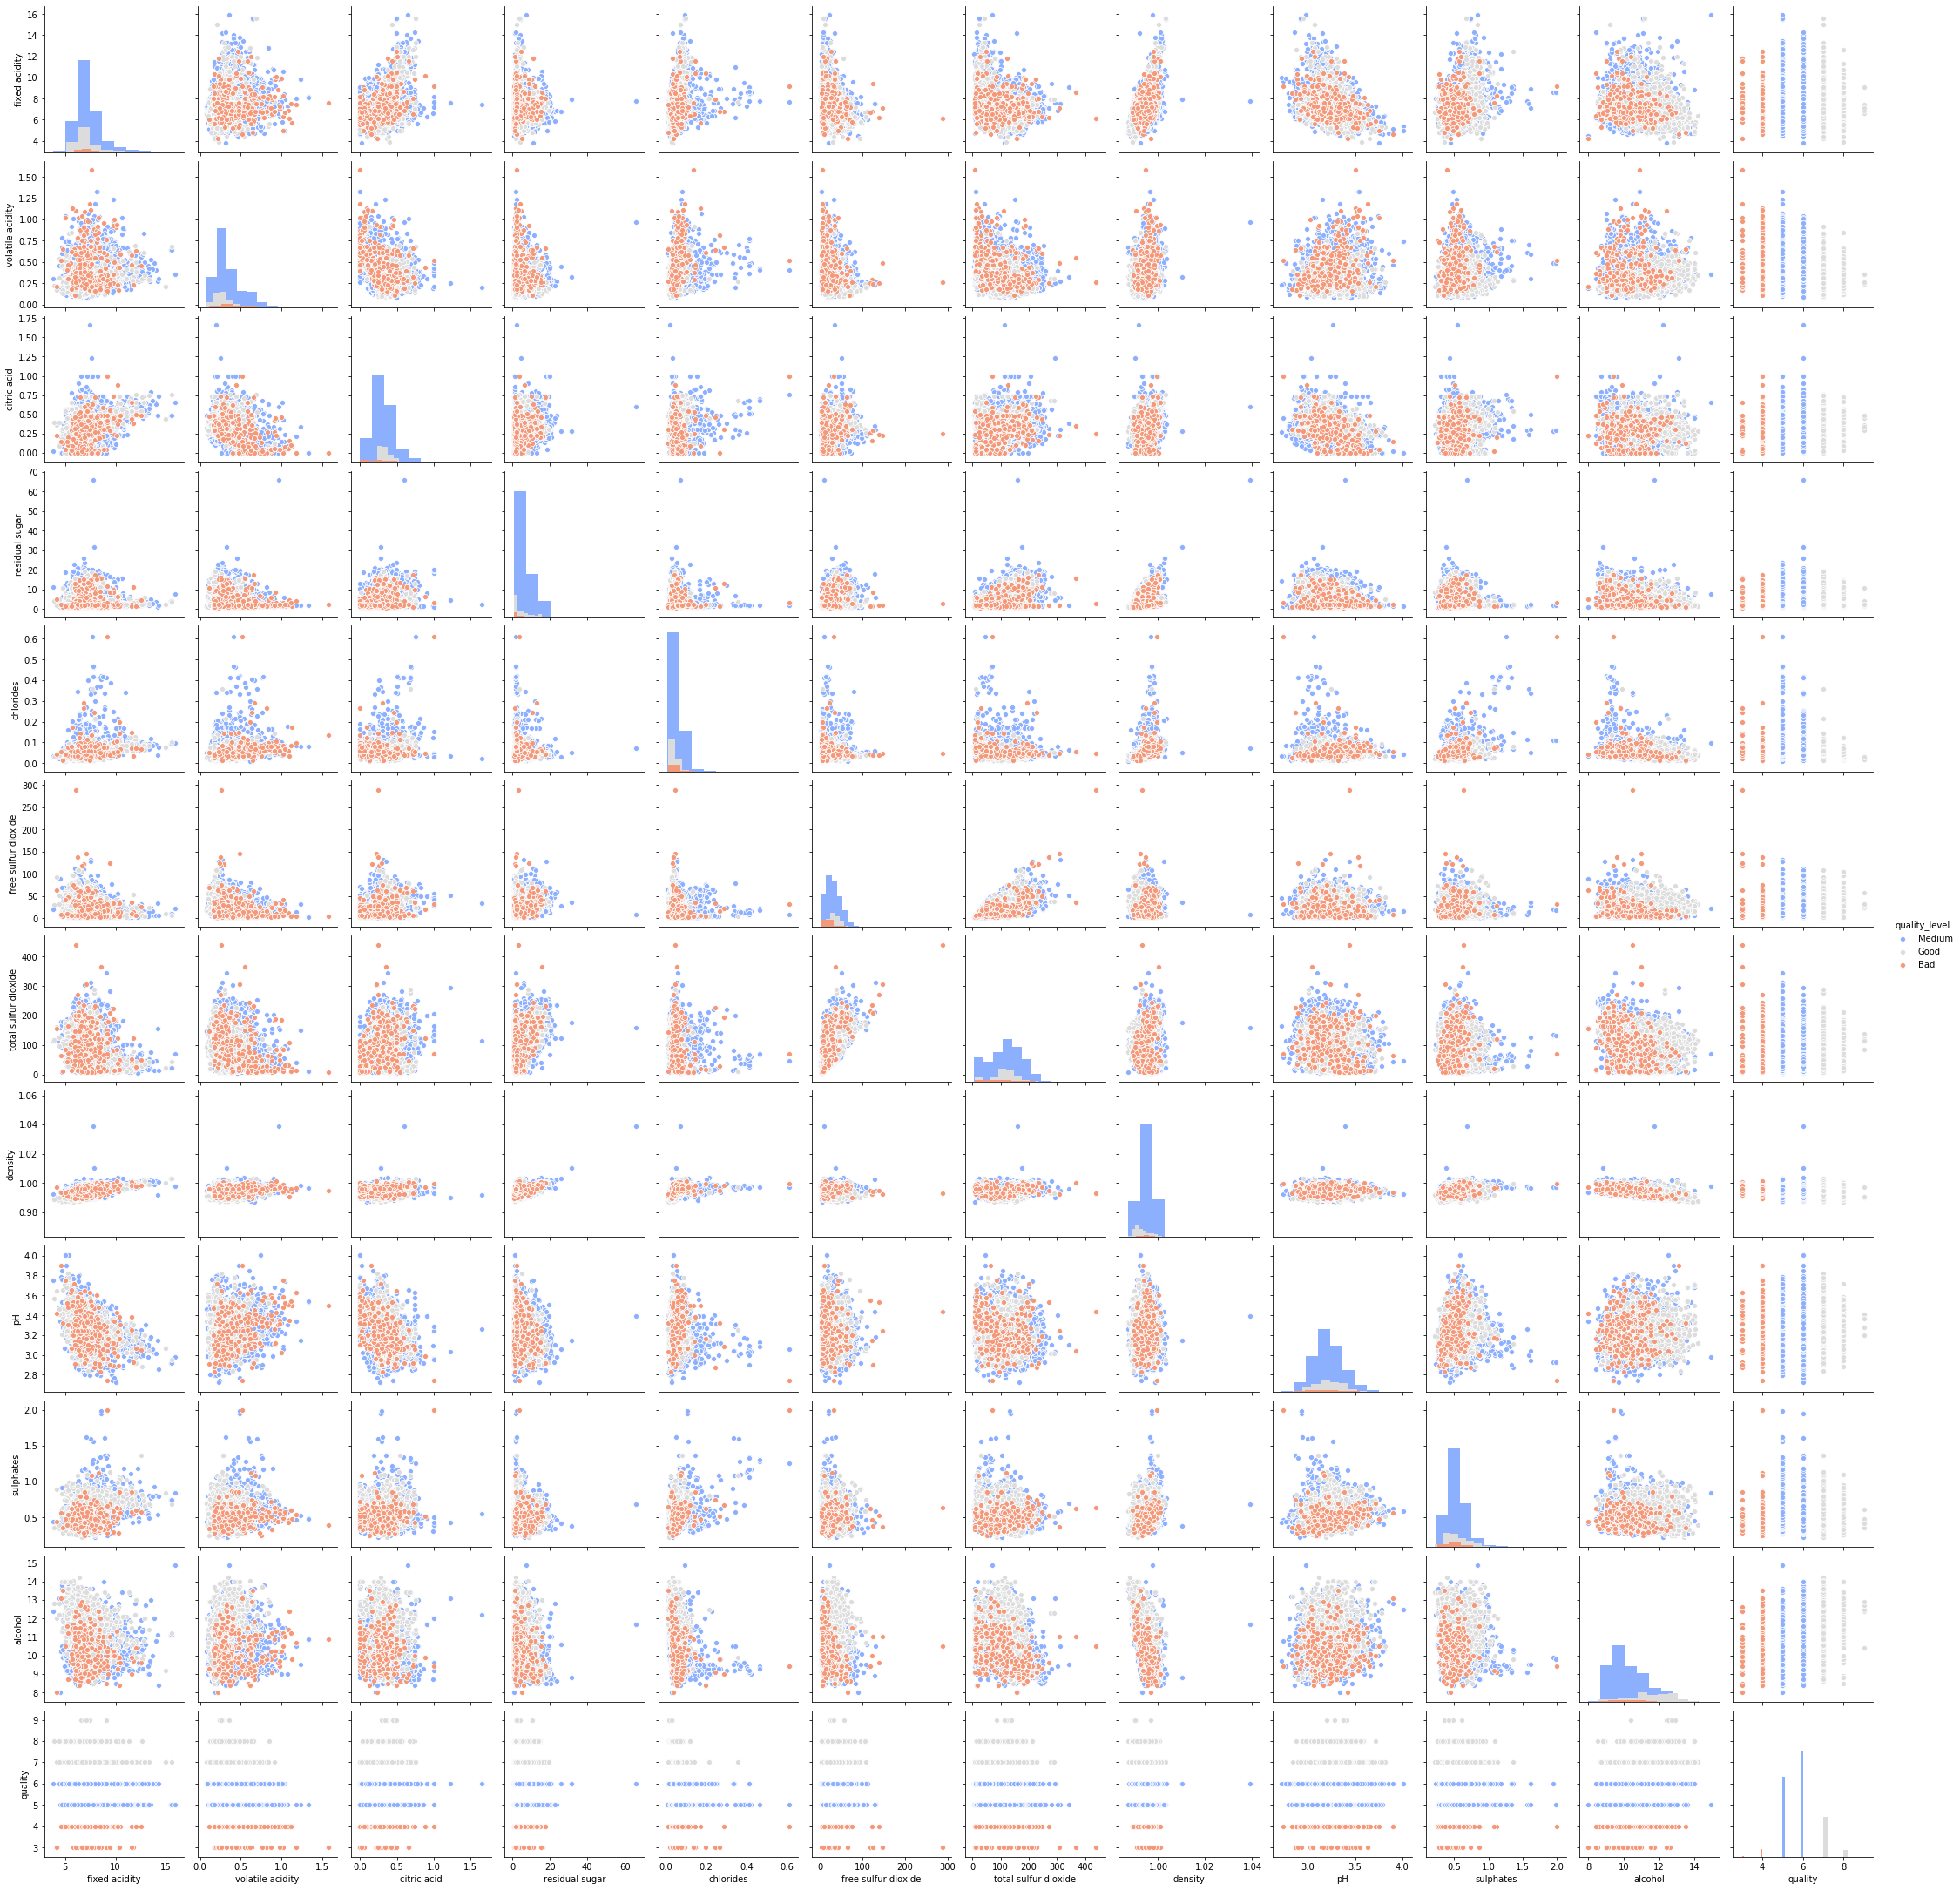

In [12]:
sns.pairplot(df, palette='coolwarm', hue='quality_level', diag_kind='hist')

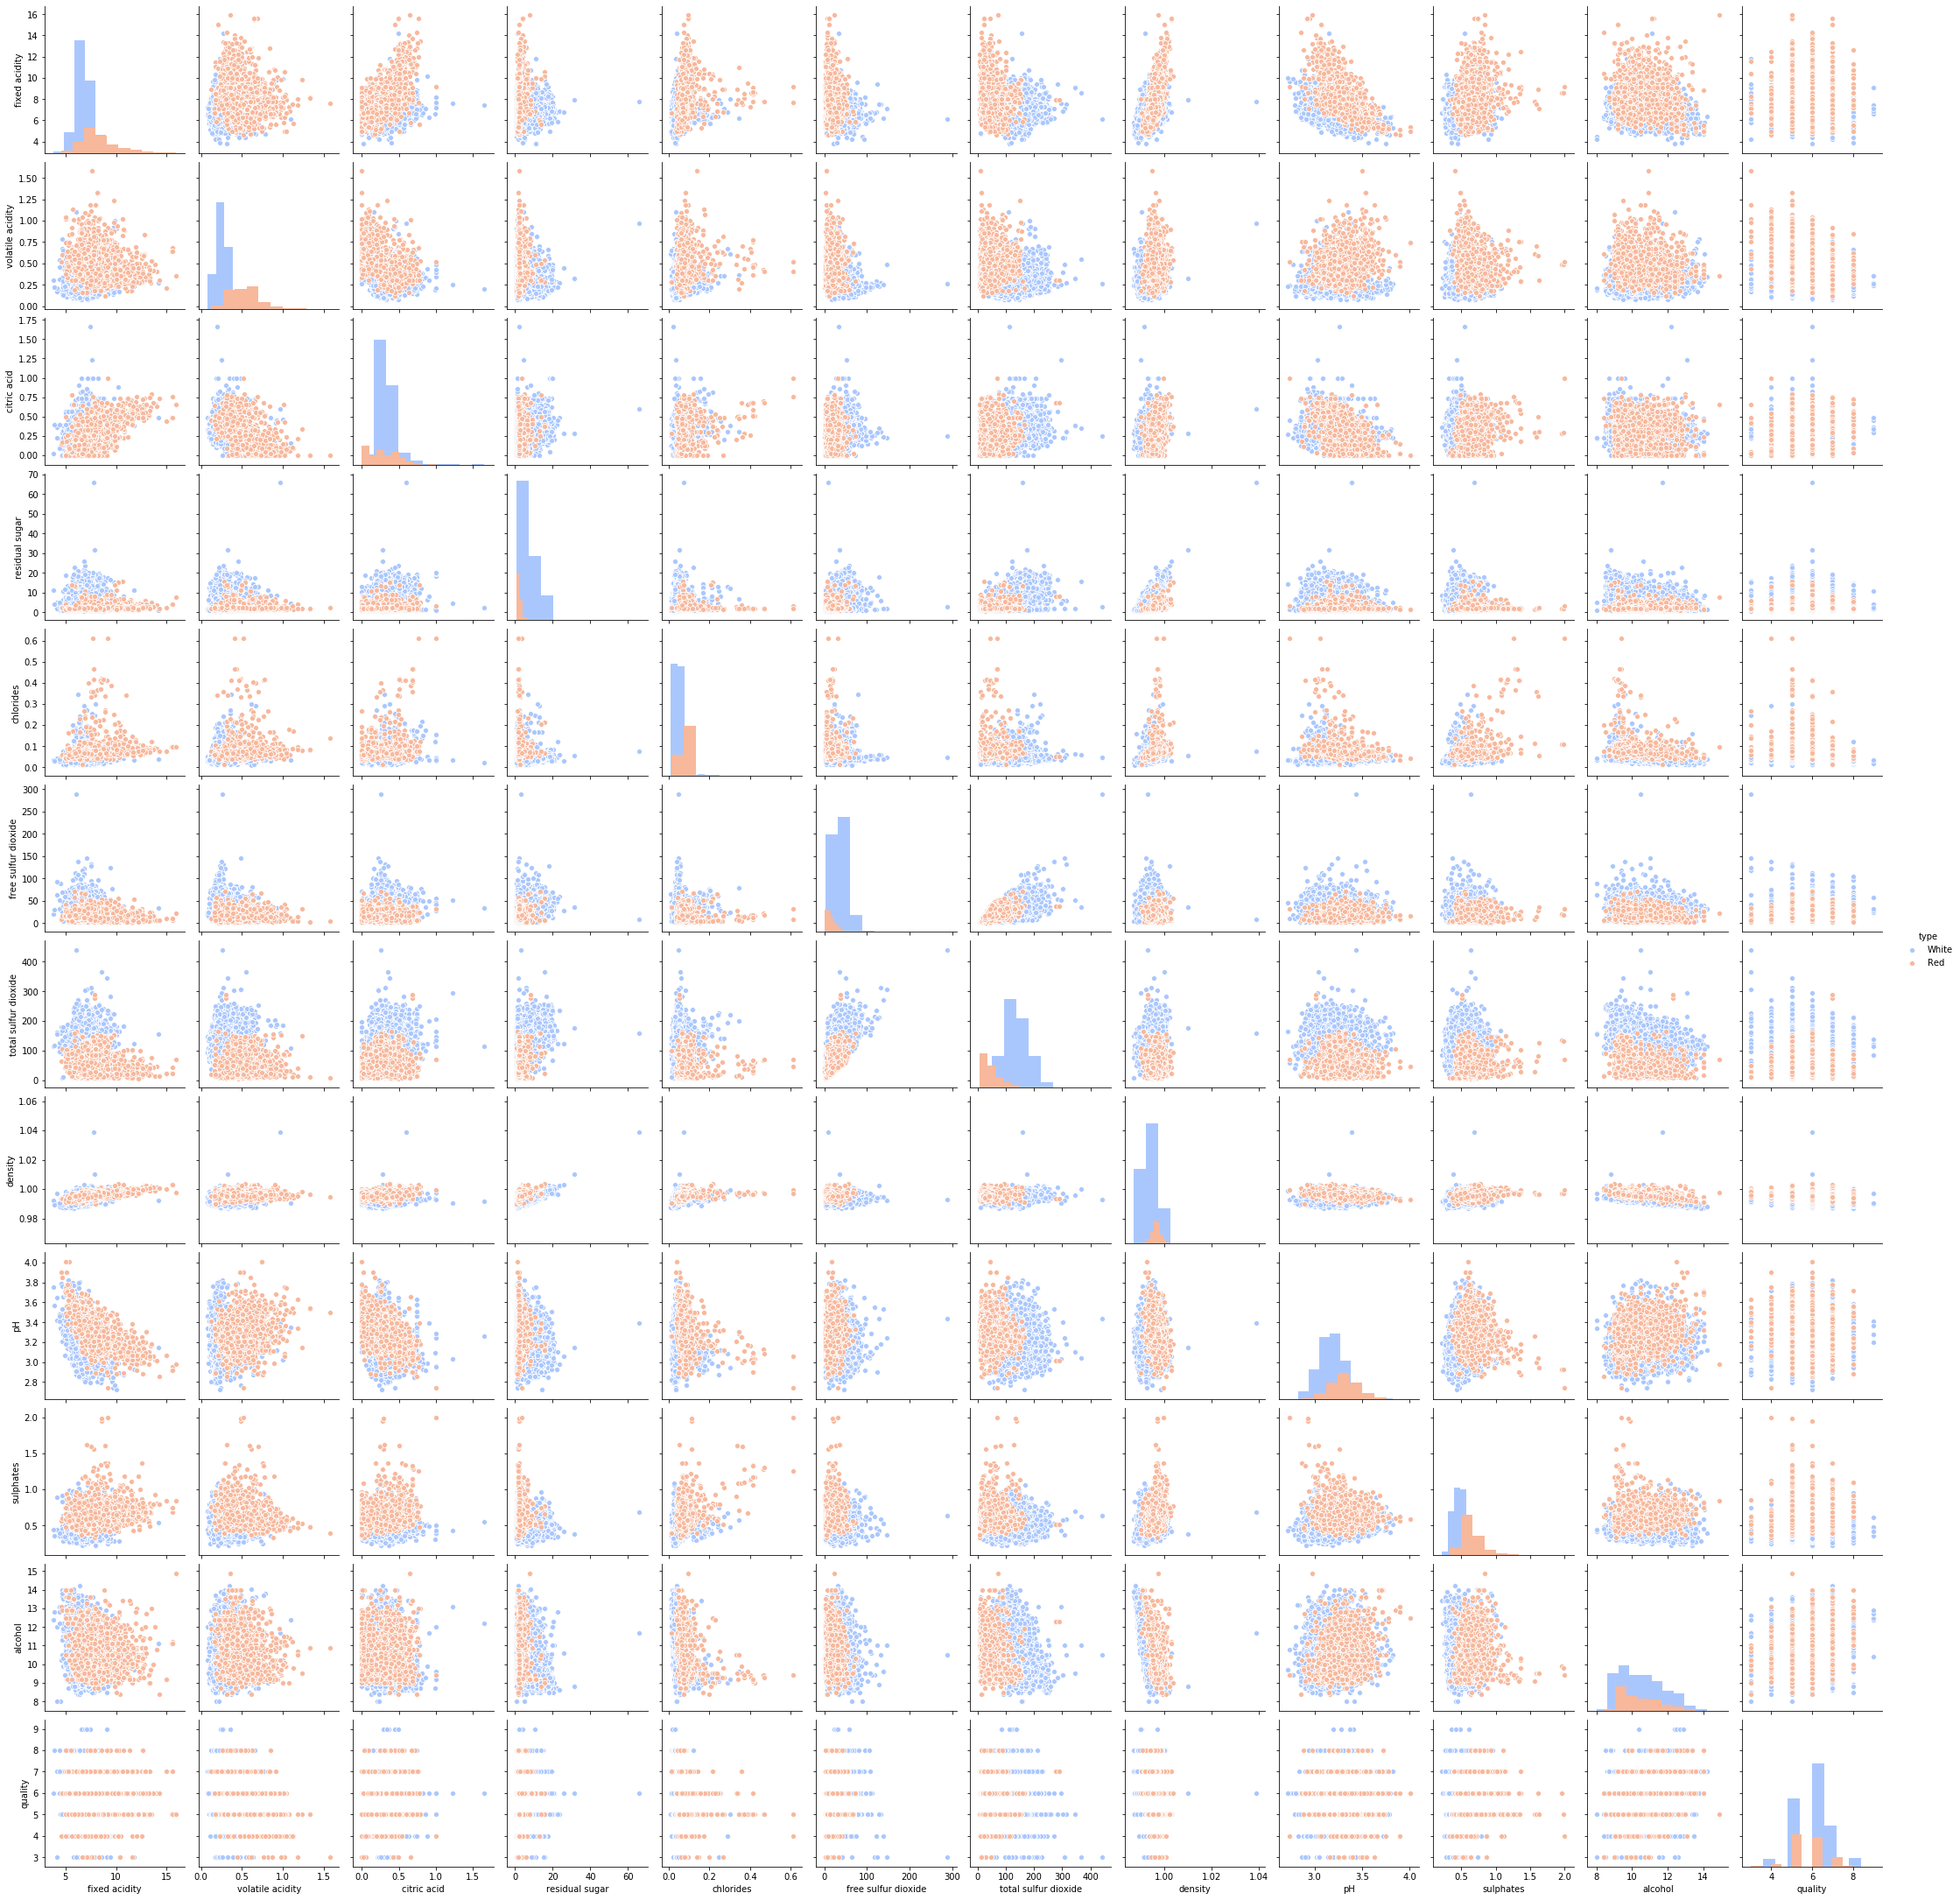

In [13]:
sns.pairplot(df, palette='coolwarm', hue='type', diag_kind='hist')

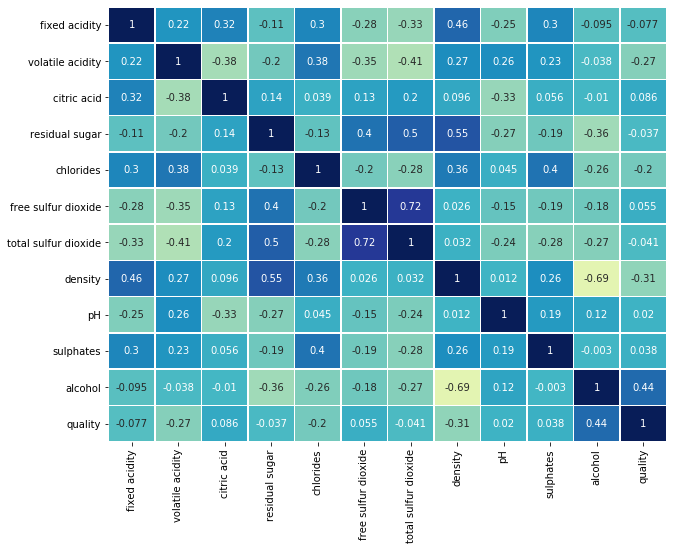

In [14]:
#Correlation plot
cor = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor, annot=True, linewidths=.5, center=0, cbar=False, cmap="YlGnBu")
plt.show()

A variável que possui maior relação direta com a variável resposta ('quality') é o teor alcólico, enquanto que a variável 'volatile acidity' possui a maior relação inversa com a variável target, ou seja, quanto menor o seu valor, maior a qualidade do vinho. Entre as variáveis independentes, a maior correlação fica por conta das variáveis relacionadas ao dióxido de enxofre, o que é evidente, pois quanto maior o nível de dióxido de enxofre total, maior será o nível deste gás livre.

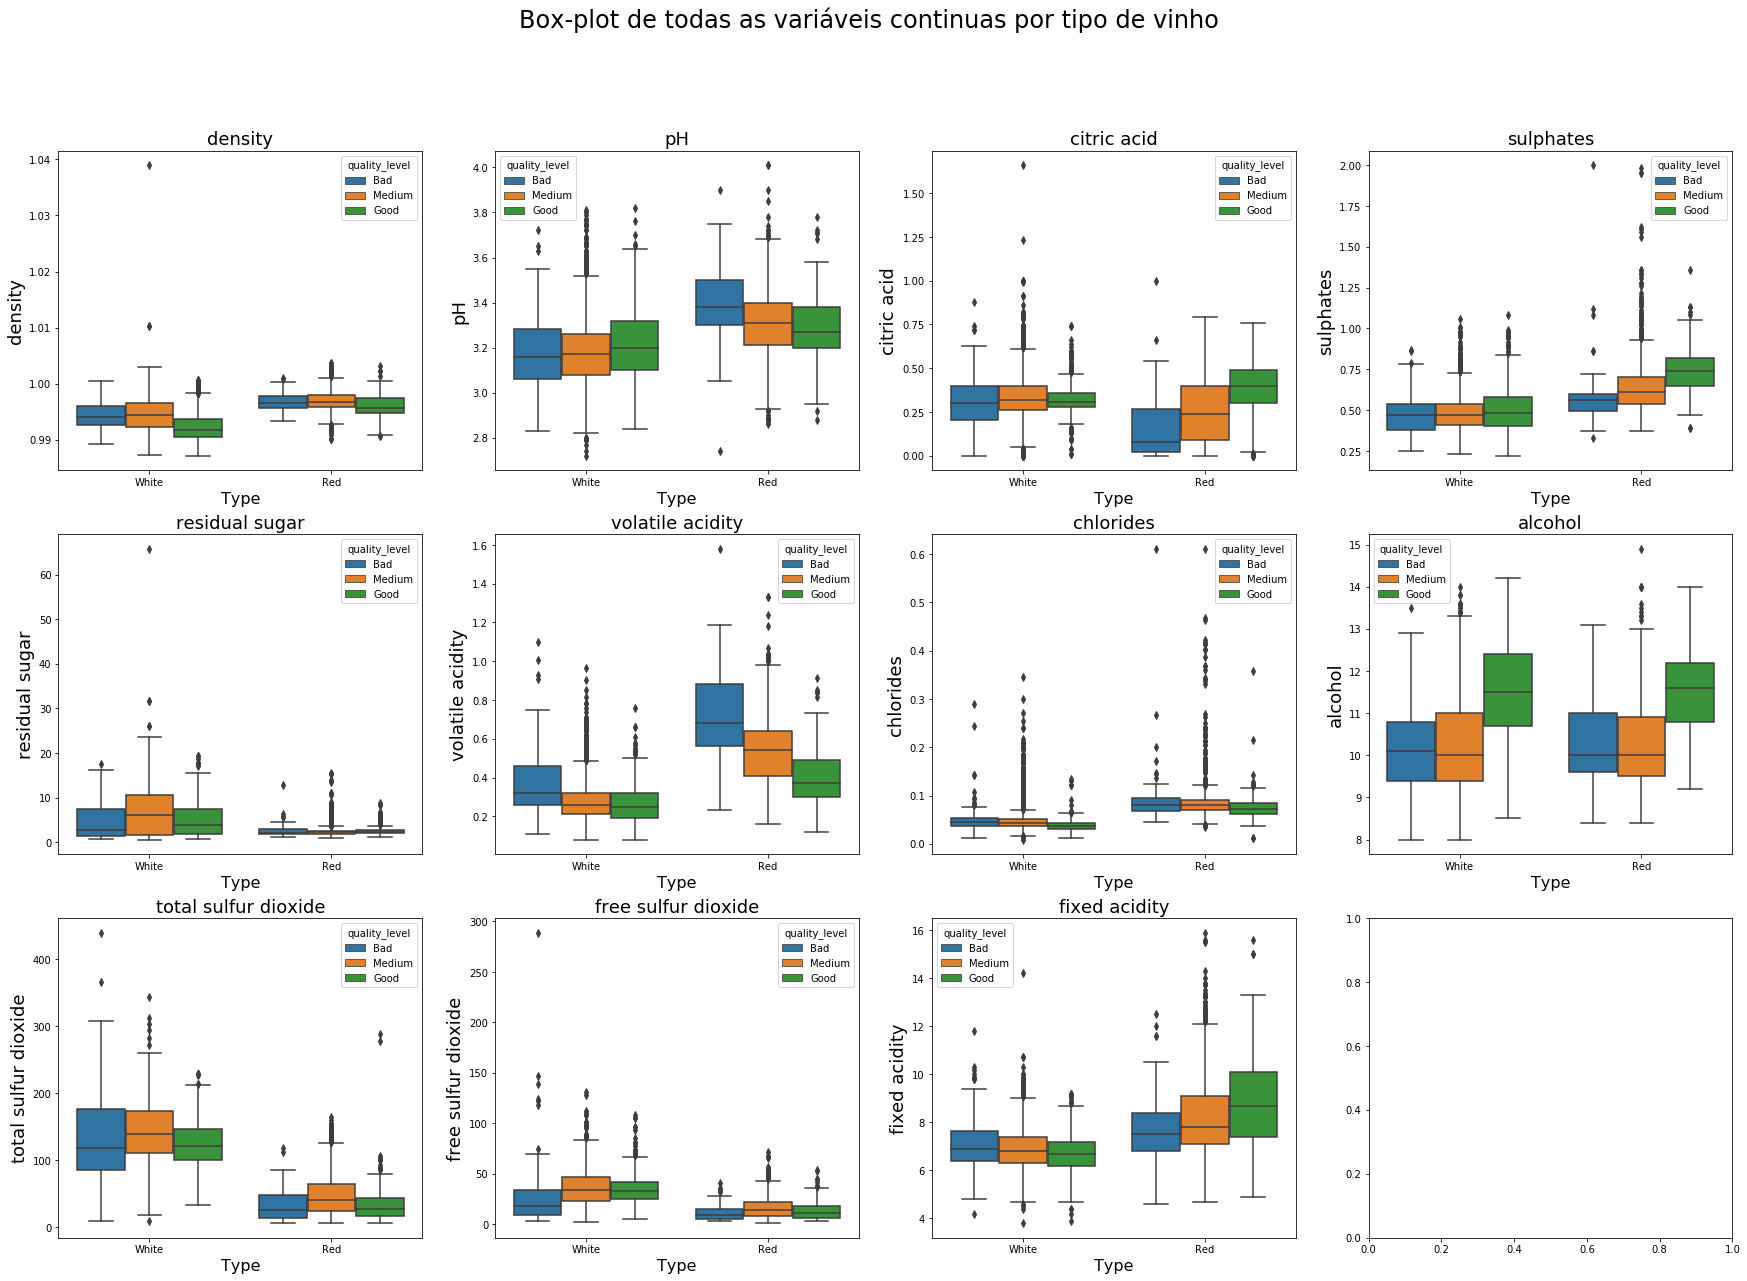

In [18]:
cont_variables = list(set(df.columns.values) - set(cat_cols) - set(['quality']))

nrows=3
ncols=4
k=0
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,20))
plt.suptitle('Box-plot de todas as variáveis continuas por tipo de vinho',fontsize=24)

for i in range(nrows):
    for j in range(ncols):
        if k ==11:
            break
            
        sns.boxplot(x='type', y=cont_variables[k], hue='quality_level',hue_order=['Bad', 'Medium', 'Good'], data=df, ax=ax[i,j])
        ax[i,j].set_ylabel(cont_variables[k],fontsize=18)
        ax[i,j].set_title(cont_variables[k],fontsize=18)
        ax[i,j].set_xlabel('Type',fontsize=16)
        k += 1

Observando os box-plots é possível confirmar o que já havia sido apresentado no HeatMap, pois os vinhos com notas de qualidade maiores ou igual a 7 possuem os três primeiros quartis bem mais elevados que os demais vinhos, independentemente do tipo de vinho (branco ou tinto). Do mesmo modo, é possível verificar a relação inversa entre a qualidade do vinho e a 'volatile acidity', os níveis desta variável são bem mais elevados para os vinhos com qualidade inferior ou igual a 4.

# Modelagem

In [19]:
# Transforamação das variáveis categóricas em dummies
newDf = pd.get_dummies(df.drop(['quality_level'], axis=1))
newDf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_Red,type_White
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


In [20]:
X_train, X_test, y_train, y_test = utils.balanced_split(newDf, with_dev=False)

# Neural Networks

In [21]:
scores_dnn, members_dnn, predictions_dnn = utils.kfold_validation(utils.evaluate_dnn, X_train, y_train, None)

>0.632
>0.596
>0.601
>0.634
>0.634
>0.612
>0.601
>0.629
>0.647
>0.614


In [22]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_dnn), np.std(scores_dnn)))

Estimated Accuracy 0.620 (0.016)


In [111]:
pred_test_dnn = utils.predicting_test(members_dnn, X_test)

In [164]:
y_test_pred_dnn = np.argmax(pred_test_dnn, axis=1)
print(classification_report(y_test, y_test_pred_dnn, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.55      0.18      0.27        33
           5       0.68      0.71      0.70       321
           6       0.63      0.69      0.66       426
           7       0.57      0.54      0.55       162
           8       0.69      0.31      0.43        29
           9       0.00      0.00      0.00         1

   micro avg       0.64      0.64      0.64       977
   macro avg       0.31      0.24      0.26       977
weighted avg       0.63      0.64      0.63       977



# XGBoost

In [24]:
param_grid = [
    {'classifier' : [xgb.XGBClassifier()],
     'classifier__booster' : ['gbtree'],
     'classifier__objective' : ['multi:softmax'],
     'classifier__eta' : [0.03, 0.1, 0.3],
     'classifier__learning_rate' : [0.03, 0.1, 0.3],
     'classifier__subsample' : [0.5, 0.8, 1],
     'classifier__colsample_bytree' : [0.5, 0.8, 1],
     'classifier__colsample_bylevel' : [0.5, 0.8, 1],
     'classifier__colsample_bynode' : [0.5, 0.8, 1],
     'classifier__max_depth' : [10, 20, 40],
     'classifier__min_child_weight' : [0, 5, 15, 300],
     'classifier__lambda': [10],
     'classifier__alpha': [10],
     'classifier__num_round':[150, 200]}]


pl_xgb = Pipeline(steps=[('scaler', StandardScaler()),
                         ('classifier', xgb.XGBClassifier())])

search_xgb = RandomizedSearchCV(pl_xgb, param_distributions = param_grid, n_iter = 300, cv = 3, verbose=0, random_state=42, n_jobs=-1)
search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('classifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                     

In [29]:
search_xgb.best_params_['classifier'].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.5,
 'colsample_bynode': 0.8,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_delta_step': 0,
 'max_depth': 20,
 'min_child_weight': 0,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softmax',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'num_round': 200,
 'lambda': 10,
 'eta': 0.03,
 'alpha': 10}

In [ ]:
# xgb_param ={'alpha':10, 'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':0.5,
#         'colsample_bynode':0.5, 'colsample_bytree':0.8, 'eta':0.015, 'gamma':0,
#         'lambda':10, 'learning_rate':0.1, 'max_delta_step':0, 'max_depth':20,
#         'min_child_weight':0, 'missing':None, 'n_estimators':800, 'n_jobs':1,
#         'nthread':None, 'num_round':400, 'objective':'multi:softmax',
#         'random_state':0, 'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
#         'seed':None, 'silent':None, 'subsample':0.8, 'verbosity':1}

In [30]:
#best_clf_xgb = search_xgb.best_params_['classifier']
xgb_param = search_xgb.best_params_['classifier'].get_params()
best_clf_xgb = xgb.XGBClassifier(**xgb_param)
best_clf_xgb.fit(sc.fit_transform(X_train), y_train)
print('Accuracy for XGB: ', best_clf_xgb.score(sc.fit_transform(X_test), y_test))

Accuracy for XGB:  0.6775844421699079


In [86]:
scores_xgb, members_xgb, predictions_xgb = utils.kfold_validation(utils.evaluate_xgb, pd.DataFrame(sc.fit_transform(X_train)), y_train, xgb_param)

>0.697
>0.654
>0.670
>0.714
>0.676
>0.687
>0.685
>0.681
>0.705
>0.701


In [87]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_xgb), np.std(scores_xgb)))

Estimated Accuracy 0.687 (0.017)


In [115]:
pred_test_xgb = utils.predicting_test(members_xgb, sc.fit_transform(X_test))

In [163]:
y_test_pred_xgb = np.argmax(pred_test_xgb, axis=1)
print(classification_report(y_test, y_test_pred_xgb, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.50      0.09      0.15        33
           5       0.72      0.73      0.73       321
           6       0.65      0.76      0.70       426
           7       0.66      0.56      0.61       162
           8       1.00      0.31      0.47        29
           9       0.00      0.00      0.00         1

   micro avg       0.68      0.68      0.68       977
   macro avg       0.35      0.25      0.27       977
weighted avg       0.68      0.68      0.67       977



# Random Forest

In [25]:
random_grid = {'rf' : [RandomForestClassifier()],
               'rf__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
               'rf__max_features': ['auto', 'sqrt'],
               'rf__max_depth': [int(x) for x in np.linspace(10, 110, num = 3)],
               'rf__min_samples_split': [2, 5, 10],
               'rf__min_samples_leaf': [1, 2, 4],
               'rf__bootstrap': [True, False]}

pl_random_forest = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('rf', RandomForestClassifier())])

search_rf = RandomizedSearchCV(pl_random_forest, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=0, random_state=42, n_jobs = -1)

search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('rf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                     

In [34]:
search_rf.best_params_['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 110,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1550,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
# params_rf = {'bootstrap': True,
#              'ccp_alpha': 0.0,
#              'class_weight': None,
#              'criterion': 'gini',
#              'max_depth': 110,
#              'max_features': 'auto',
#              'max_leaf_nodes': None,
#              'max_samples': None,
#              'min_impurity_decrease': 0.0,
#              'min_impurity_split': None,
#              'min_samples_leaf': 1,
#              'min_samples_split': 2,
#              'min_weight_fraction_leaf': 0.0,
#              'n_estimators': 650,
#              'n_jobs': None,
#              'oob_score': False,
#              'random_state': None,
#              'verbose': 0,
#              'warm_start': False
#             }

In [36]:
#best_clf_rf = search_rf.best_params_['rf']
params_rf = search_rf.best_params_['rf'].get_params()
best_clf_rf = RandomForestClassifier(**params_rf)
best_clf_rf.fit(sc.fit_transform(X_train), y_train)
print('Accuracy for RF: ', best_clf_rf.score(sc.fit_transform(X_test), y_test))

Accuracy for RF:  0.676560900716479


In [84]:
scores_rf, members_rf, predictions_rf = utils.kfold_validation(utils.evaluate_rf, pd.DataFrame(sc.fit_transform(X_train)), y_train, params_rf)

>0.690
>0.645
>0.683
>0.725
>0.683
>0.681
>0.688
>0.696
>0.721
>0.719


In [85]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_rf), np.std(scores_rf)))

Estimated Accuracy 0.693 (0.023)


In [118]:
pred_test_rf = utils.predicting_test(members_rf, sc.fit_transform(X_test))

In [162]:
y_test_pred_rf = np.argmax(pred_test_rf, axis=1)
print(classification_report(y_test, y_test_pred_rf, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.67      0.06      0.11        33
           5       0.74      0.73      0.74       321
           6       0.65      0.78      0.71       426
           7       0.67      0.58      0.62       162
           8       1.00      0.31      0.47        29
           9       0.00      0.00      0.00         1

   micro avg       0.69      0.69      0.69       977
   macro avg       0.37      0.25      0.27       977
weighted avg       0.69      0.69      0.67       977



# CatBoost

In [26]:
param_grid = [
    {'CatBoost' : [CatBoostClassifier()],
     'CatBoost__loss_function': ['MultiClass'],
     'CatBoost__depth':[4, 7, 10],
     'CatBoost__iterations':[100,500,1000],
     'CatBoost__learning_rate':[0.03,0.001,0.01,0.1,0.3], 
     'CatBoost__l2_leaf_reg':[1,5,10],
     'CatBoost__thread_count': [4]}
]

pl_cb = Pipeline(steps=[('scaler', StandardScaler()),
                        ('CatBoost', CatBoostClassifier())])

search_cb = RandomizedSearchCV(pl_cb, 
                               param_distributions = param_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=0, 
                               random_state=42, 
                               n_jobs=-1)

search_cb.fit(X_train, y_train)

0:	learn: 1.5367980	total: 98.3ms	remaining: 49s
1:	learn: 1.3458435	total: 141ms	remaining: 35.1s
2:	learn: 1.2399397	total: 180ms	remaining: 29.9s
3:	learn: 1.1739378	total: 222ms	remaining: 27.5s
4:	learn: 1.1177061	total: 265ms	remaining: 26.3s
5:	learn: 1.0807607	total: 309ms	remaining: 25.5s
6:	learn: 1.0517337	total: 377ms	remaining: 26.5s
7:	learn: 1.0265258	total: 414ms	remaining: 25.5s
8:	learn: 1.0047784	total: 453ms	remaining: 24.7s
9:	learn: 0.9877729	total: 492ms	remaining: 24.1s
10:	learn: 0.9741228	total: 540ms	remaining: 24s
11:	learn: 0.9633769	total: 579ms	remaining: 23.6s
12:	learn: 0.9491879	total: 619ms	remaining: 23.2s
13:	learn: 0.9383989	total: 659ms	remaining: 22.9s
14:	learn: 0.9297740	total: 708ms	remaining: 22.9s
15:	learn: 0.9149744	total: 749ms	remaining: 22.7s
16:	learn: 0.9007379	total: 793ms	remaining: 22.5s
17:	learn: 0.8900694	total: 839ms	remaining: 22.5s
18:	learn: 0.8827913	total: 890ms	remaining: 22.5s
19:	learn: 0.8757035	total: 947ms	remaining:

162:	learn: 0.3138644	total: 7.63s	remaining: 15.8s
163:	learn: 0.3093760	total: 7.68s	remaining: 15.7s
164:	learn: 0.3077651	total: 7.72s	remaining: 15.7s
165:	learn: 0.3048977	total: 7.76s	remaining: 15.6s
166:	learn: 0.3022491	total: 7.81s	remaining: 15.6s
167:	learn: 0.3011479	total: 7.85s	remaining: 15.5s
168:	learn: 0.2992641	total: 7.9s	remaining: 15.5s
169:	learn: 0.2978308	total: 7.95s	remaining: 15.4s
170:	learn: 0.2954677	total: 7.99s	remaining: 15.4s
171:	learn: 0.2943458	total: 8.02s	remaining: 15.3s
172:	learn: 0.2924657	total: 8.08s	remaining: 15.3s
173:	learn: 0.2905077	total: 8.12s	remaining: 15.2s
174:	learn: 0.2890040	total: 8.16s	remaining: 15.2s
175:	learn: 0.2879046	total: 8.21s	remaining: 15.1s
176:	learn: 0.2870205	total: 8.26s	remaining: 15.1s
177:	learn: 0.2853457	total: 8.3s	remaining: 15s
178:	learn: 0.2829238	total: 8.36s	remaining: 15s
179:	learn: 0.2825973	total: 8.42s	remaining: 15s
180:	learn: 0.2808393	total: 8.48s	remaining: 14.9s
181:	learn: 0.279707

321:	learn: 0.1412604	total: 16s	remaining: 8.86s
322:	learn: 0.1406224	total: 16.1s	remaining: 8.8s
323:	learn: 0.1400145	total: 16.1s	remaining: 8.74s
324:	learn: 0.1389363	total: 16.1s	remaining: 8.68s
325:	learn: 0.1384953	total: 16.2s	remaining: 8.62s
326:	learn: 0.1382108	total: 16.2s	remaining: 8.56s
327:	learn: 0.1376087	total: 16.2s	remaining: 8.51s
328:	learn: 0.1370216	total: 16.3s	remaining: 8.45s
329:	learn: 0.1363201	total: 16.3s	remaining: 8.39s
330:	learn: 0.1358629	total: 16.3s	remaining: 8.34s
331:	learn: 0.1353068	total: 16.4s	remaining: 8.28s
332:	learn: 0.1342996	total: 16.4s	remaining: 8.22s
333:	learn: 0.1338748	total: 16.4s	remaining: 8.16s
334:	learn: 0.1335695	total: 16.5s	remaining: 8.11s
335:	learn: 0.1326341	total: 16.5s	remaining: 8.06s
336:	learn: 0.1319120	total: 16.5s	remaining: 8s
337:	learn: 0.1314369	total: 16.6s	remaining: 7.95s
338:	learn: 0.1312522	total: 16.6s	remaining: 7.89s
339:	learn: 0.1309922	total: 16.7s	remaining: 7.84s
340:	learn: 0.1305

485:	learn: 0.0774785	total: 21.8s	remaining: 629ms
486:	learn: 0.0773065	total: 21.9s	remaining: 583ms
487:	learn: 0.0770967	total: 21.9s	remaining: 538ms
488:	learn: 0.0767434	total: 21.9s	remaining: 493ms
489:	learn: 0.0765690	total: 21.9s	remaining: 448ms
490:	learn: 0.0762866	total: 22s	remaining: 403ms
491:	learn: 0.0760323	total: 22s	remaining: 358ms
492:	learn: 0.0757449	total: 22.1s	remaining: 313ms
493:	learn: 0.0754736	total: 22.1s	remaining: 268ms
494:	learn: 0.0753804	total: 22.1s	remaining: 223ms
495:	learn: 0.0752161	total: 22.2s	remaining: 179ms
496:	learn: 0.0750278	total: 22.2s	remaining: 134ms
497:	learn: 0.0747789	total: 22.2s	remaining: 89.2ms
498:	learn: 0.0745513	total: 22.2s	remaining: 44.6ms
499:	learn: 0.0743374	total: 22.3s	remaining: 0us


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('CatBoost',
                                              <catboost.core.CatBoostClassifier object at 0x1a777a1450>)],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions=[{'CatBoost': [<catboost.core.CatBoostClassifier object at 0x1a77277f50>],
                                         'CatBoost__depth': [4, 7, 10],
                                         'CatBoost__iterations': [100, 500,
                                                                  1000],
          

In [40]:
search_cb.best_params_['CatBoost'].get_params()

{'thread_count': 4,
 'loss_function': 'MultiClass',
 'learning_rate': 0.3,
 'l2_leaf_reg': 1,
 'iterations': 500,
 'depth': 7}

In [41]:
cb_param = {'thread_count': 4,
 'loss_function': 'MultiClass',
 'learning_rate': 0.3,
 'l2_leaf_reg': 1,
 'iterations': 500,
 'depth': 7}

In [42]:
#best_clf_cb = search_rf.best_params_['CatBoost']
cb_param = search_cb.best_params_['CatBoost'].get_params()
best_clf_cb = CatBoostClassifier(**cb_param)
best_clf_cb.fit(sc.fit_transform(X_train), y_train)
print('Accuracy for CatBoost: ', best_clf_cb.score(sc.fit_transform(X_test), y_test))

0:	learn: 1.5367980	total: 83.8ms	remaining: 41.8s
1:	learn: 1.3458435	total: 121ms	remaining: 30.2s
2:	learn: 1.2399397	total: 152ms	remaining: 25.2s
3:	learn: 1.1739378	total: 182ms	remaining: 22.6s
4:	learn: 1.1177061	total: 217ms	remaining: 21.5s
5:	learn: 1.0807607	total: 245ms	remaining: 20.2s
6:	learn: 1.0517337	total: 273ms	remaining: 19.2s
7:	learn: 1.0265258	total: 307ms	remaining: 18.9s
8:	learn: 1.0047784	total: 336ms	remaining: 18.3s
9:	learn: 0.9877729	total: 364ms	remaining: 17.9s
10:	learn: 0.9741228	total: 394ms	remaining: 17.5s
11:	learn: 0.9633769	total: 428ms	remaining: 17.4s
12:	learn: 0.9491879	total: 456ms	remaining: 17.1s
13:	learn: 0.9383989	total: 488ms	remaining: 17s
14:	learn: 0.9297740	total: 522ms	remaining: 16.9s
15:	learn: 0.9149744	total: 552ms	remaining: 16.7s
16:	learn: 0.9007379	total: 593ms	remaining: 16.9s
17:	learn: 0.8900694	total: 636ms	remaining: 17s
18:	learn: 0.8827913	total: 671ms	remaining: 17s
19:	learn: 0.8757035	total: 707ms	remaining: 1

163:	learn: 0.3093760	total: 6.75s	remaining: 13.8s
164:	learn: 0.3077651	total: 6.8s	remaining: 13.8s
165:	learn: 0.3048977	total: 6.88s	remaining: 13.8s
166:	learn: 0.3022491	total: 6.93s	remaining: 13.8s
167:	learn: 0.3011479	total: 6.97s	remaining: 13.8s
168:	learn: 0.2992641	total: 7.01s	remaining: 13.7s
169:	learn: 0.2978308	total: 7.06s	remaining: 13.7s
170:	learn: 0.2954677	total: 7.1s	remaining: 13.7s
171:	learn: 0.2943458	total: 7.14s	remaining: 13.6s
172:	learn: 0.2924657	total: 7.18s	remaining: 13.6s
173:	learn: 0.2905077	total: 7.21s	remaining: 13.5s
174:	learn: 0.2890040	total: 7.25s	remaining: 13.5s
175:	learn: 0.2879046	total: 7.3s	remaining: 13.4s
176:	learn: 0.2870205	total: 7.39s	remaining: 13.5s
177:	learn: 0.2853457	total: 7.48s	remaining: 13.5s
178:	learn: 0.2829238	total: 7.58s	remaining: 13.6s
179:	learn: 0.2825973	total: 7.74s	remaining: 13.8s
180:	learn: 0.2808393	total: 7.81s	remaining: 13.8s
181:	learn: 0.2797078	total: 7.85s	remaining: 13.7s
182:	learn: 0.2

325:	learn: 0.1384953	total: 14s	remaining: 7.47s
326:	learn: 0.1382108	total: 14s	remaining: 7.42s
327:	learn: 0.1376087	total: 14.1s	remaining: 7.38s
328:	learn: 0.1370216	total: 14.1s	remaining: 7.33s
329:	learn: 0.1363201	total: 14.2s	remaining: 7.29s
330:	learn: 0.1358629	total: 14.2s	remaining: 7.25s
331:	learn: 0.1353068	total: 14.2s	remaining: 7.2s
332:	learn: 0.1342996	total: 14.3s	remaining: 7.16s
333:	learn: 0.1338748	total: 14.3s	remaining: 7.12s
334:	learn: 0.1335695	total: 14.4s	remaining: 7.07s
335:	learn: 0.1326341	total: 14.4s	remaining: 7.02s
336:	learn: 0.1319120	total: 14.4s	remaining: 6.98s
337:	learn: 0.1314369	total: 14.5s	remaining: 6.93s
338:	learn: 0.1312522	total: 14.5s	remaining: 6.89s
339:	learn: 0.1309922	total: 14.5s	remaining: 6.84s
340:	learn: 0.1305287	total: 14.6s	remaining: 6.79s
341:	learn: 0.1299399	total: 14.6s	remaining: 6.75s
342:	learn: 0.1292064	total: 14.6s	remaining: 6.7s
343:	learn: 0.1288533	total: 14.7s	remaining: 6.66s
344:	learn: 0.1281

487:	learn: 0.0770967	total: 19.8s	remaining: 486ms
488:	learn: 0.0767434	total: 19.8s	remaining: 445ms
489:	learn: 0.0765690	total: 19.8s	remaining: 405ms
490:	learn: 0.0762866	total: 19.9s	remaining: 364ms
491:	learn: 0.0760323	total: 19.9s	remaining: 323ms
492:	learn: 0.0757449	total: 19.9s	remaining: 283ms
493:	learn: 0.0754736	total: 19.9s	remaining: 242ms
494:	learn: 0.0753804	total: 20s	remaining: 202ms
495:	learn: 0.0752161	total: 20s	remaining: 161ms
496:	learn: 0.0750278	total: 20s	remaining: 121ms
497:	learn: 0.0747789	total: 20.1s	remaining: 80.6ms
498:	learn: 0.0745513	total: 20.1s	remaining: 40.3ms
499:	learn: 0.0743374	total: 20.2s	remaining: 0us
Accuracy for CatBoost:  0.6734902763561924


In [82]:
scores_cb, members_cb, predictions_cb = utils.kfold_validation(utils.evaluate_cb, pd.DataFrame(sc.fit_transform(X_train)), y_train, cb_param)

0:	learn: 1.5173582	total: 29.6ms	remaining: 14.8s
1:	learn: 1.3469670	total: 58.5ms	remaining: 14.6s
2:	learn: 1.2406745	total: 85.6ms	remaining: 14.2s
3:	learn: 1.1712136	total: 115ms	remaining: 14.3s
4:	learn: 1.1142443	total: 144ms	remaining: 14.3s
5:	learn: 1.0823097	total: 176ms	remaining: 14.5s
6:	learn: 1.0512809	total: 206ms	remaining: 14.5s
7:	learn: 1.0243316	total: 235ms	remaining: 14.4s
8:	learn: 1.0012087	total: 275ms	remaining: 15s
9:	learn: 0.9850199	total: 304ms	remaining: 14.9s
10:	learn: 0.9746804	total: 331ms	remaining: 14.7s
11:	learn: 0.9588888	total: 359ms	remaining: 14.6s
12:	learn: 0.9423390	total: 389ms	remaining: 14.6s
13:	learn: 0.9233381	total: 421ms	remaining: 14.6s
14:	learn: 0.9146376	total: 468ms	remaining: 15.1s
15:	learn: 0.9045722	total: 516ms	remaining: 15.6s
16:	learn: 0.9002178	total: 549ms	remaining: 15.6s
17:	learn: 0.8928249	total: 580ms	remaining: 15.5s
18:	learn: 0.8810741	total: 612ms	remaining: 15.5s
19:	learn: 0.8757373	total: 642ms	remain

163:	learn: 0.2962737	total: 5.9s	remaining: 12.1s
164:	learn: 0.2932963	total: 5.95s	remaining: 12.1s
165:	learn: 0.2921454	total: 5.97s	remaining: 12s
166:	learn: 0.2901079	total: 6.04s	remaining: 12s
167:	learn: 0.2884873	total: 6.1s	remaining: 12.1s
168:	learn: 0.2861330	total: 6.36s	remaining: 12.5s
169:	learn: 0.2845247	total: 6.41s	remaining: 12.4s
170:	learn: 0.2815205	total: 6.51s	remaining: 12.5s
171:	learn: 0.2797257	total: 6.67s	remaining: 12.7s
172:	learn: 0.2779635	total: 6.74s	remaining: 12.7s
173:	learn: 0.2757522	total: 6.77s	remaining: 12.7s
174:	learn: 0.2743105	total: 6.8s	remaining: 12.6s
175:	learn: 0.2722775	total: 6.84s	remaining: 12.6s
176:	learn: 0.2703520	total: 6.88s	remaining: 12.6s
177:	learn: 0.2679763	total: 6.92s	remaining: 12.5s
178:	learn: 0.2669285	total: 6.96s	remaining: 12.5s
179:	learn: 0.2647039	total: 6.99s	remaining: 12.4s
180:	learn: 0.2634403	total: 7.03s	remaining: 12.4s
181:	learn: 0.2619992	total: 7.07s	remaining: 12.3s
182:	learn: 0.26099

328:	learn: 0.1226958	total: 13.1s	remaining: 6.8s
329:	learn: 0.1222534	total: 13.1s	remaining: 6.76s
330:	learn: 0.1217370	total: 13.2s	remaining: 6.71s
331:	learn: 0.1214861	total: 13.2s	remaining: 6.67s
332:	learn: 0.1210443	total: 13.2s	remaining: 6.62s
333:	learn: 0.1204282	total: 13.2s	remaining: 6.58s
334:	learn: 0.1195558	total: 13.3s	remaining: 6.53s
335:	learn: 0.1190691	total: 13.3s	remaining: 6.49s
336:	learn: 0.1187204	total: 13.3s	remaining: 6.45s
337:	learn: 0.1181978	total: 13.4s	remaining: 6.41s
338:	learn: 0.1175376	total: 13.4s	remaining: 6.37s
339:	learn: 0.1169778	total: 13.5s	remaining: 6.33s
340:	learn: 0.1164454	total: 13.5s	remaining: 6.29s
341:	learn: 0.1157525	total: 13.5s	remaining: 6.25s
342:	learn: 0.1150605	total: 13.6s	remaining: 6.21s
343:	learn: 0.1148904	total: 13.6s	remaining: 6.16s
344:	learn: 0.1144894	total: 13.6s	remaining: 6.12s
345:	learn: 0.1142363	total: 13.7s	remaining: 6.08s
346:	learn: 0.1138564	total: 13.7s	remaining: 6.03s
347:	learn: 0

489:	learn: 0.0686116	total: 18.4s	remaining: 375ms
490:	learn: 0.0683637	total: 18.4s	remaining: 337ms
491:	learn: 0.0682019	total: 18.4s	remaining: 300ms
492:	learn: 0.0679691	total: 18.5s	remaining: 262ms
493:	learn: 0.0676717	total: 18.5s	remaining: 225ms
494:	learn: 0.0675189	total: 18.5s	remaining: 187ms
495:	learn: 0.0673927	total: 18.6s	remaining: 150ms
496:	learn: 0.0672515	total: 18.6s	remaining: 112ms
497:	learn: 0.0669238	total: 18.6s	remaining: 74.8ms
498:	learn: 0.0667325	total: 18.7s	remaining: 37.4ms
499:	learn: 0.0665308	total: 18.7s	remaining: 0us
>0.678
0:	learn: 1.5365771	total: 33.3ms	remaining: 16.6s
1:	learn: 1.3479473	total: 70.8ms	remaining: 17.6s
2:	learn: 1.2417090	total: 105ms	remaining: 17.4s
3:	learn: 1.1716287	total: 131ms	remaining: 16.3s
4:	learn: 1.1139675	total: 159ms	remaining: 15.8s
5:	learn: 1.0829307	total: 190ms	remaining: 15.7s
6:	learn: 1.0515645	total: 227ms	remaining: 16s
7:	learn: 1.0281200	total: 272ms	remaining: 16.7s
8:	learn: 1.0123230	t

151:	learn: 0.3172306	total: 5.38s	remaining: 12.3s
152:	learn: 0.3144739	total: 5.41s	remaining: 12.3s
153:	learn: 0.3118457	total: 5.44s	remaining: 12.2s
154:	learn: 0.3090592	total: 5.46s	remaining: 12.2s
155:	learn: 0.3071989	total: 5.5s	remaining: 12.1s
156:	learn: 0.3047730	total: 5.53s	remaining: 12.1s
157:	learn: 0.3024967	total: 5.57s	remaining: 12s
158:	learn: 0.2994544	total: 5.61s	remaining: 12s
159:	learn: 0.2971597	total: 5.65s	remaining: 12s
160:	learn: 0.2951988	total: 5.68s	remaining: 12s
161:	learn: 0.2920545	total: 5.72s	remaining: 11.9s
162:	learn: 0.2900818	total: 5.75s	remaining: 11.9s
163:	learn: 0.2886869	total: 5.78s	remaining: 11.8s
164:	learn: 0.2865073	total: 5.81s	remaining: 11.8s
165:	learn: 0.2851698	total: 5.84s	remaining: 11.8s
166:	learn: 0.2841876	total: 5.87s	remaining: 11.7s
167:	learn: 0.2816485	total: 5.9s	remaining: 11.7s
168:	learn: 0.2798190	total: 5.93s	remaining: 11.6s
169:	learn: 0.2781741	total: 5.96s	remaining: 11.6s
170:	learn: 0.2769177	

311:	learn: 0.1372881	total: 11.4s	remaining: 6.88s
312:	learn: 0.1365324	total: 11.5s	remaining: 6.84s
313:	learn: 0.1362007	total: 11.5s	remaining: 6.8s
314:	learn: 0.1352164	total: 11.5s	remaining: 6.76s
315:	learn: 0.1347626	total: 11.5s	remaining: 6.72s
316:	learn: 0.1345360	total: 11.6s	remaining: 6.68s
317:	learn: 0.1338962	total: 11.6s	remaining: 6.64s
318:	learn: 0.1333433	total: 11.7s	remaining: 6.61s
319:	learn: 0.1328452	total: 11.7s	remaining: 6.57s
320:	learn: 0.1321371	total: 11.7s	remaining: 6.53s
321:	learn: 0.1317611	total: 11.7s	remaining: 6.49s
322:	learn: 0.1312386	total: 11.8s	remaining: 6.45s
323:	learn: 0.1309134	total: 11.8s	remaining: 6.41s
324:	learn: 0.1303588	total: 11.8s	remaining: 6.37s
325:	learn: 0.1296413	total: 11.9s	remaining: 6.33s
326:	learn: 0.1291224	total: 11.9s	remaining: 6.3s
327:	learn: 0.1282148	total: 11.9s	remaining: 6.27s
328:	learn: 0.1275749	total: 12s	remaining: 6.23s
329:	learn: 0.1267113	total: 12s	remaining: 6.19s
330:	learn: 0.1255

472:	learn: 0.0733570	total: 16.7s	remaining: 956ms
473:	learn: 0.0731131	total: 16.8s	remaining: 920ms
474:	learn: 0.0728554	total: 16.8s	remaining: 884ms
475:	learn: 0.0726613	total: 16.8s	remaining: 849ms
476:	learn: 0.0724736	total: 16.9s	remaining: 813ms
477:	learn: 0.0722120	total: 16.9s	remaining: 778ms
478:	learn: 0.0718063	total: 16.9s	remaining: 742ms
479:	learn: 0.0716585	total: 17s	remaining: 706ms
480:	learn: 0.0713802	total: 17s	remaining: 672ms
481:	learn: 0.0712319	total: 17.1s	remaining: 637ms
482:	learn: 0.0709807	total: 17.1s	remaining: 602ms
483:	learn: 0.0707988	total: 17.2s	remaining: 567ms
484:	learn: 0.0704937	total: 17.2s	remaining: 532ms
485:	learn: 0.0701592	total: 17.2s	remaining: 496ms
486:	learn: 0.0699118	total: 17.3s	remaining: 461ms
487:	learn: 0.0698393	total: 17.3s	remaining: 425ms
488:	learn: 0.0695190	total: 17.3s	remaining: 389ms
489:	learn: 0.0692453	total: 17.3s	remaining: 354ms
490:	learn: 0.0690641	total: 17.4s	remaining: 318ms
491:	learn: 0.06

133:	learn: 0.3471679	total: 4.62s	remaining: 12.6s
134:	learn: 0.3460130	total: 4.67s	remaining: 12.6s
135:	learn: 0.3441220	total: 4.7s	remaining: 12.6s
136:	learn: 0.3428941	total: 4.74s	remaining: 12.6s
137:	learn: 0.3408174	total: 4.78s	remaining: 12.5s
138:	learn: 0.3394376	total: 4.82s	remaining: 12.5s
139:	learn: 0.3359110	total: 5.09s	remaining: 13.1s
140:	learn: 0.3340239	total: 5.13s	remaining: 13s
141:	learn: 0.3326468	total: 5.15s	remaining: 13s
142:	learn: 0.3319771	total: 5.18s	remaining: 12.9s
143:	learn: 0.3300382	total: 5.22s	remaining: 12.9s
144:	learn: 0.3292988	total: 5.26s	remaining: 12.9s
145:	learn: 0.3265384	total: 5.29s	remaining: 12.8s
146:	learn: 0.3251514	total: 5.33s	remaining: 12.8s
147:	learn: 0.3223397	total: 5.36s	remaining: 12.7s
148:	learn: 0.3200357	total: 5.39s	remaining: 12.7s
149:	learn: 0.3184834	total: 5.42s	remaining: 12.6s
150:	learn: 0.3164350	total: 5.45s	remaining: 12.6s
151:	learn: 0.3144067	total: 5.47s	remaining: 12.5s
152:	learn: 0.313

294:	learn: 0.1472544	total: 10.4s	remaining: 7.23s
295:	learn: 0.1465533	total: 10.4s	remaining: 7.19s
296:	learn: 0.1459956	total: 10.5s	remaining: 7.16s
297:	learn: 0.1453857	total: 10.5s	remaining: 7.13s
298:	learn: 0.1446791	total: 10.5s	remaining: 7.09s
299:	learn: 0.1440600	total: 10.6s	remaining: 7.06s
300:	learn: 0.1432854	total: 10.6s	remaining: 7.04s
301:	learn: 0.1428063	total: 10.7s	remaining: 7.01s
302:	learn: 0.1421324	total: 10.7s	remaining: 6.97s
303:	learn: 0.1415894	total: 10.8s	remaining: 6.94s
304:	learn: 0.1413117	total: 10.8s	remaining: 6.9s
305:	learn: 0.1403910	total: 10.8s	remaining: 6.86s
306:	learn: 0.1394957	total: 10.9s	remaining: 6.82s
307:	learn: 0.1388557	total: 10.9s	remaining: 6.79s
308:	learn: 0.1381128	total: 10.9s	remaining: 6.75s
309:	learn: 0.1375843	total: 10.9s	remaining: 6.71s
310:	learn: 0.1372152	total: 11s	remaining: 6.67s
311:	learn: 0.1362786	total: 11s	remaining: 6.63s
312:	learn: 0.1358033	total: 11s	remaining: 6.59s
313:	learn: 0.13550

453:	learn: 0.0785034	total: 15.5s	remaining: 1.57s
454:	learn: 0.0783590	total: 15.6s	remaining: 1.54s
455:	learn: 0.0779872	total: 15.6s	remaining: 1.5s
456:	learn: 0.0777093	total: 15.6s	remaining: 1.47s
457:	learn: 0.0774045	total: 15.7s	remaining: 1.44s
458:	learn: 0.0771503	total: 15.7s	remaining: 1.4s
459:	learn: 0.0769767	total: 15.7s	remaining: 1.36s
460:	learn: 0.0768198	total: 15.7s	remaining: 1.33s
461:	learn: 0.0763817	total: 15.8s	remaining: 1.3s
462:	learn: 0.0760916	total: 15.8s	remaining: 1.26s
463:	learn: 0.0757339	total: 15.8s	remaining: 1.23s
464:	learn: 0.0755663	total: 15.9s	remaining: 1.19s
465:	learn: 0.0754423	total: 15.9s	remaining: 1.16s
466:	learn: 0.0753114	total: 15.9s	remaining: 1.13s
467:	learn: 0.0751224	total: 16s	remaining: 1.09s
468:	learn: 0.0749978	total: 16s	remaining: 1.06s
469:	learn: 0.0747041	total: 16s	remaining: 1.02s
470:	learn: 0.0743556	total: 16s	remaining: 988ms
471:	learn: 0.0742504	total: 16.1s	remaining: 954ms
472:	learn: 0.0739594	t

114:	learn: 0.3975272	total: 4.16s	remaining: 13.9s
115:	learn: 0.3953153	total: 4.2s	remaining: 13.9s
116:	learn: 0.3912813	total: 4.23s	remaining: 13.9s
117:	learn: 0.3870792	total: 4.27s	remaining: 13.8s
118:	learn: 0.3834349	total: 4.31s	remaining: 13.8s
119:	learn: 0.3818615	total: 4.34s	remaining: 13.7s
120:	learn: 0.3799624	total: 4.38s	remaining: 13.7s
121:	learn: 0.3769003	total: 4.42s	remaining: 13.7s
122:	learn: 0.3745832	total: 4.46s	remaining: 13.7s
123:	learn: 0.3735150	total: 4.49s	remaining: 13.6s
124:	learn: 0.3696491	total: 4.53s	remaining: 13.6s
125:	learn: 0.3679633	total: 4.56s	remaining: 13.5s
126:	learn: 0.3664037	total: 4.61s	remaining: 13.5s
127:	learn: 0.3633380	total: 4.63s	remaining: 13.5s
128:	learn: 0.3609449	total: 4.66s	remaining: 13.4s
129:	learn: 0.3579798	total: 4.69s	remaining: 13.4s
130:	learn: 0.3563494	total: 4.73s	remaining: 13.3s
131:	learn: 0.3552054	total: 4.76s	remaining: 13.3s
132:	learn: 0.3533383	total: 4.78s	remaining: 13.2s
133:	learn: 0

278:	learn: 0.1586812	total: 9.96s	remaining: 7.89s
279:	learn: 0.1577506	total: 9.99s	remaining: 7.85s
280:	learn: 0.1568423	total: 10s	remaining: 7.81s
281:	learn: 0.1559133	total: 10.1s	remaining: 7.78s
282:	learn: 0.1551740	total: 10.1s	remaining: 7.74s
283:	learn: 0.1543224	total: 10.1s	remaining: 7.7s
284:	learn: 0.1534940	total: 10.2s	remaining: 7.68s
285:	learn: 0.1529479	total: 10.2s	remaining: 7.65s
286:	learn: 0.1525401	total: 10.3s	remaining: 7.61s
287:	learn: 0.1521818	total: 10.3s	remaining: 7.58s
288:	learn: 0.1513945	total: 10.3s	remaining: 7.54s
289:	learn: 0.1509254	total: 10.4s	remaining: 7.51s
290:	learn: 0.1499616	total: 10.4s	remaining: 7.48s
291:	learn: 0.1492244	total: 10.4s	remaining: 7.44s
292:	learn: 0.1483322	total: 10.5s	remaining: 7.4s
293:	learn: 0.1477237	total: 10.5s	remaining: 7.37s
294:	learn: 0.1471816	total: 10.5s	remaining: 7.32s
295:	learn: 0.1461634	total: 10.6s	remaining: 7.29s
296:	learn: 0.1452391	total: 10.6s	remaining: 7.25s
297:	learn: 0.14

442:	learn: 0.0806672	total: 14.9s	remaining: 1.91s
443:	learn: 0.0804689	total: 14.9s	remaining: 1.88s
444:	learn: 0.0800056	total: 14.9s	remaining: 1.85s
445:	learn: 0.0799285	total: 15s	remaining: 1.81s
446:	learn: 0.0796266	total: 15s	remaining: 1.78s
447:	learn: 0.0790488	total: 15s	remaining: 1.74s
448:	learn: 0.0789634	total: 15s	remaining: 1.71s
449:	learn: 0.0786543	total: 15.1s	remaining: 1.67s
450:	learn: 0.0782199	total: 15.1s	remaining: 1.64s
451:	learn: 0.0778879	total: 15.1s	remaining: 1.61s
452:	learn: 0.0776704	total: 15.2s	remaining: 1.57s
453:	learn: 0.0774753	total: 15.2s	remaining: 1.54s
454:	learn: 0.0772391	total: 15.2s	remaining: 1.5s
455:	learn: 0.0769359	total: 15.2s	remaining: 1.47s
456:	learn: 0.0767162	total: 15.3s	remaining: 1.44s
457:	learn: 0.0765805	total: 15.3s	remaining: 1.4s
458:	learn: 0.0764221	total: 15.3s	remaining: 1.37s
459:	learn: 0.0762579	total: 15.4s	remaining: 1.34s
460:	learn: 0.0759803	total: 15.4s	remaining: 1.3s
461:	learn: 0.0756737	t

103:	learn: 0.4349570	total: 4.68s	remaining: 17.8s
104:	learn: 0.4322335	total: 4.71s	remaining: 17.7s
105:	learn: 0.4289358	total: 4.74s	remaining: 17.6s
106:	learn: 0.4270692	total: 4.77s	remaining: 17.5s
107:	learn: 0.4250388	total: 4.8s	remaining: 17.4s
108:	learn: 0.4230599	total: 4.83s	remaining: 17.3s
109:	learn: 0.4173253	total: 4.87s	remaining: 17.3s
110:	learn: 0.4143966	total: 4.91s	remaining: 17.2s
111:	learn: 0.4115268	total: 4.94s	remaining: 17.1s
112:	learn: 0.4091128	total: 4.99s	remaining: 17.1s
113:	learn: 0.4063829	total: 5.04s	remaining: 17.1s
114:	learn: 0.4032369	total: 5.14s	remaining: 17.2s
115:	learn: 0.3987948	total: 5.19s	remaining: 17.2s
116:	learn: 0.3946807	total: 5.22s	remaining: 17.1s
117:	learn: 0.3917082	total: 5.25s	remaining: 17s
118:	learn: 0.3893907	total: 5.27s	remaining: 16.9s
119:	learn: 0.3864847	total: 5.3s	remaining: 16.8s
120:	learn: 0.3841114	total: 5.33s	remaining: 16.7s
121:	learn: 0.3805793	total: 5.38s	remaining: 16.7s
122:	learn: 0.37

267:	learn: 0.1664636	total: 10.6s	remaining: 9.15s
268:	learn: 0.1653113	total: 10.6s	remaining: 9.1s
269:	learn: 0.1635637	total: 10.6s	remaining: 9.05s
270:	learn: 0.1631253	total: 10.7s	remaining: 9.01s
271:	learn: 0.1621938	total: 10.7s	remaining: 8.96s
272:	learn: 0.1615375	total: 10.7s	remaining: 8.91s
273:	learn: 0.1610899	total: 10.7s	remaining: 8.86s
274:	learn: 0.1601873	total: 10.8s	remaining: 8.82s
275:	learn: 0.1598833	total: 10.8s	remaining: 8.78s
276:	learn: 0.1592596	total: 10.8s	remaining: 8.73s
277:	learn: 0.1587828	total: 10.9s	remaining: 8.69s
278:	learn: 0.1577064	total: 10.9s	remaining: 8.64s
279:	learn: 0.1569770	total: 10.9s	remaining: 8.6s
280:	learn: 0.1563402	total: 11s	remaining: 8.55s
281:	learn: 0.1558069	total: 11s	remaining: 8.53s
282:	learn: 0.1549435	total: 11.1s	remaining: 8.49s
283:	learn: 0.1545716	total: 11.1s	remaining: 8.45s
284:	learn: 0.1536726	total: 11.1s	remaining: 8.4s
285:	learn: 0.1524954	total: 11.2s	remaining: 8.36s
286:	learn: 0.15197

432:	learn: 0.0835877	total: 15.8s	remaining: 2.44s
433:	learn: 0.0832598	total: 15.8s	remaining: 2.4s
434:	learn: 0.0828201	total: 15.8s	remaining: 2.36s
435:	learn: 0.0826521	total: 15.8s	remaining: 2.33s
436:	learn: 0.0823436	total: 15.9s	remaining: 2.29s
437:	learn: 0.0820161	total: 15.9s	remaining: 2.25s
438:	learn: 0.0818564	total: 15.9s	remaining: 2.21s
439:	learn: 0.0815540	total: 16s	remaining: 2.18s
440:	learn: 0.0813479	total: 16s	remaining: 2.14s
441:	learn: 0.0810651	total: 16s	remaining: 2.1s
442:	learn: 0.0809125	total: 16s	remaining: 2.06s
443:	learn: 0.0803943	total: 16.1s	remaining: 2.03s
444:	learn: 0.0798407	total: 16.1s	remaining: 1.99s
445:	learn: 0.0794568	total: 16.1s	remaining: 1.95s
446:	learn: 0.0791833	total: 16.2s	remaining: 1.92s
447:	learn: 0.0791416	total: 16.2s	remaining: 1.88s
448:	learn: 0.0787699	total: 16.2s	remaining: 1.84s
449:	learn: 0.0784247	total: 16.3s	remaining: 1.81s
450:	learn: 0.0781430	total: 16.3s	remaining: 1.77s
451:	learn: 0.0779499	

96:	learn: 0.4566060	total: 3.52s	remaining: 14.6s
97:	learn: 0.4534274	total: 3.56s	remaining: 14.6s
98:	learn: 0.4480585	total: 3.6s	remaining: 14.6s
99:	learn: 0.4453346	total: 3.64s	remaining: 14.6s
100:	learn: 0.4418814	total: 3.67s	remaining: 14.5s
101:	learn: 0.4359491	total: 3.71s	remaining: 14.5s
102:	learn: 0.4325800	total: 3.76s	remaining: 14.5s
103:	learn: 0.4296955	total: 3.79s	remaining: 14.4s
104:	learn: 0.4275797	total: 3.83s	remaining: 14.4s
105:	learn: 0.4252325	total: 3.85s	remaining: 14.3s
106:	learn: 0.4210714	total: 3.89s	remaining: 14.3s
107:	learn: 0.4158679	total: 3.91s	remaining: 14.2s
108:	learn: 0.4130201	total: 3.94s	remaining: 14.1s
109:	learn: 0.4112266	total: 3.97s	remaining: 14.1s
110:	learn: 0.4074014	total: 4s	remaining: 14s
111:	learn: 0.4019186	total: 4.03s	remaining: 14s
112:	learn: 0.4002954	total: 4.06s	remaining: 13.9s
113:	learn: 0.3981364	total: 4.09s	remaining: 13.8s
114:	learn: 0.3971373	total: 4.12s	remaining: 13.8s
115:	learn: 0.3949753	to

260:	learn: 0.1770270	total: 8.87s	remaining: 8.12s
261:	learn: 0.1761818	total: 8.91s	remaining: 8.09s
262:	learn: 0.1754728	total: 8.94s	remaining: 8.05s
263:	learn: 0.1741795	total: 8.96s	remaining: 8.01s
264:	learn: 0.1734605	total: 8.99s	remaining: 7.97s
265:	learn: 0.1727987	total: 9.03s	remaining: 7.94s
266:	learn: 0.1721786	total: 9.06s	remaining: 7.91s
267:	learn: 0.1716130	total: 9.12s	remaining: 7.89s
268:	learn: 0.1706057	total: 9.15s	remaining: 7.86s
269:	learn: 0.1700746	total: 9.19s	remaining: 7.83s
270:	learn: 0.1693410	total: 9.22s	remaining: 7.79s
271:	learn: 0.1683605	total: 9.26s	remaining: 7.76s
272:	learn: 0.1675791	total: 9.29s	remaining: 7.73s
273:	learn: 0.1670551	total: 9.33s	remaining: 7.69s
274:	learn: 0.1665119	total: 9.36s	remaining: 7.66s
275:	learn: 0.1657782	total: 9.39s	remaining: 7.62s
276:	learn: 0.1646438	total: 9.42s	remaining: 7.58s
277:	learn: 0.1640833	total: 9.45s	remaining: 7.54s
278:	learn: 0.1630601	total: 9.49s	remaining: 7.51s
279:	learn: 

422:	learn: 0.0879373	total: 14.2s	remaining: 2.58s
423:	learn: 0.0876323	total: 14.2s	remaining: 2.55s
424:	learn: 0.0868959	total: 14.3s	remaining: 2.52s
425:	learn: 0.0866021	total: 14.3s	remaining: 2.48s
426:	learn: 0.0863392	total: 14.3s	remaining: 2.45s
427:	learn: 0.0859850	total: 14.4s	remaining: 2.41s
428:	learn: 0.0856145	total: 14.4s	remaining: 2.38s
429:	learn: 0.0853637	total: 14.4s	remaining: 2.35s
430:	learn: 0.0850329	total: 14.5s	remaining: 2.31s
431:	learn: 0.0848990	total: 14.5s	remaining: 2.28s
432:	learn: 0.0844365	total: 14.5s	remaining: 2.25s
433:	learn: 0.0839130	total: 14.5s	remaining: 2.21s
434:	learn: 0.0836579	total: 14.6s	remaining: 2.18s
435:	learn: 0.0833013	total: 14.6s	remaining: 2.14s
436:	learn: 0.0827301	total: 14.6s	remaining: 2.11s
437:	learn: 0.0825124	total: 14.7s	remaining: 2.08s
438:	learn: 0.0822357	total: 14.7s	remaining: 2.04s
439:	learn: 0.0819040	total: 14.7s	remaining: 2.01s
440:	learn: 0.0817375	total: 14.8s	remaining: 1.97s
441:	learn: 

84:	learn: 0.5089739	total: 2.97s	remaining: 14.5s
85:	learn: 0.5059669	total: 3.04s	remaining: 14.6s
86:	learn: 0.5013865	total: 3.08s	remaining: 14.6s
87:	learn: 0.4946188	total: 3.11s	remaining: 14.6s
88:	learn: 0.4915901	total: 3.15s	remaining: 14.5s
89:	learn: 0.4880817	total: 3.19s	remaining: 14.5s
90:	learn: 0.4840749	total: 3.23s	remaining: 14.5s
91:	learn: 0.4798399	total: 3.25s	remaining: 14.4s
92:	learn: 0.4754620	total: 3.29s	remaining: 14.4s
93:	learn: 0.4724167	total: 3.33s	remaining: 14.4s
94:	learn: 0.4701173	total: 3.36s	remaining: 14.3s
95:	learn: 0.4671813	total: 3.39s	remaining: 14.3s
96:	learn: 0.4648801	total: 3.43s	remaining: 14.2s
97:	learn: 0.4614816	total: 3.46s	remaining: 14.2s
98:	learn: 0.4576369	total: 3.5s	remaining: 14.2s
99:	learn: 0.4538224	total: 3.54s	remaining: 14.2s
100:	learn: 0.4492662	total: 3.58s	remaining: 14.1s
101:	learn: 0.4440155	total: 3.64s	remaining: 14.2s
102:	learn: 0.4406445	total: 3.67s	remaining: 14.2s
103:	learn: 0.4385758	total: 

245:	learn: 0.1901944	total: 8.58s	remaining: 8.86s
246:	learn: 0.1889902	total: 8.61s	remaining: 8.82s
247:	learn: 0.1883703	total: 8.64s	remaining: 8.78s
248:	learn: 0.1873897	total: 8.66s	remaining: 8.73s
249:	learn: 0.1870552	total: 8.69s	remaining: 8.69s
250:	learn: 0.1866619	total: 8.73s	remaining: 8.66s
251:	learn: 0.1858606	total: 8.77s	remaining: 8.63s
252:	learn: 0.1849929	total: 8.82s	remaining: 8.61s
253:	learn: 0.1837907	total: 8.85s	remaining: 8.57s
254:	learn: 0.1828056	total: 8.9s	remaining: 8.55s
255:	learn: 0.1821586	total: 8.94s	remaining: 8.52s
256:	learn: 0.1812459	total: 8.98s	remaining: 8.49s
257:	learn: 0.1803524	total: 9.02s	remaining: 8.46s
258:	learn: 0.1787681	total: 9.07s	remaining: 8.44s
259:	learn: 0.1780312	total: 9.11s	remaining: 8.4s
260:	learn: 0.1771337	total: 9.14s	remaining: 8.37s
261:	learn: 0.1763485	total: 9.18s	remaining: 8.33s
262:	learn: 0.1749626	total: 9.2s	remaining: 8.29s
263:	learn: 0.1743746	total: 9.24s	remaining: 8.26s
264:	learn: 0.1

405:	learn: 0.0978425	total: 16.2s	remaining: 3.75s
406:	learn: 0.0974050	total: 16.3s	remaining: 3.71s
407:	learn: 0.0969939	total: 16.3s	remaining: 3.68s
408:	learn: 0.0967281	total: 16.3s	remaining: 3.64s
409:	learn: 0.0964012	total: 16.4s	remaining: 3.59s
410:	learn: 0.0961372	total: 16.4s	remaining: 3.55s
411:	learn: 0.0957203	total: 16.4s	remaining: 3.51s
412:	learn: 0.0954688	total: 16.5s	remaining: 3.47s
413:	learn: 0.0951564	total: 16.5s	remaining: 3.43s
414:	learn: 0.0948570	total: 16.5s	remaining: 3.39s
415:	learn: 0.0943418	total: 16.6s	remaining: 3.35s
416:	learn: 0.0940010	total: 16.6s	remaining: 3.31s
417:	learn: 0.0937980	total: 16.6s	remaining: 3.26s
418:	learn: 0.0934351	total: 16.7s	remaining: 3.23s
419:	learn: 0.0930823	total: 16.7s	remaining: 3.18s
420:	learn: 0.0927471	total: 16.8s	remaining: 3.14s
421:	learn: 0.0924626	total: 16.8s	remaining: 3.1s
422:	learn: 0.0922047	total: 16.8s	remaining: 3.06s
423:	learn: 0.0919438	total: 16.9s	remaining: 3.02s
424:	learn: 0

69:	learn: 0.5645708	total: 2.39s	remaining: 14.7s
70:	learn: 0.5604245	total: 2.42s	remaining: 14.6s
71:	learn: 0.5578517	total: 2.45s	remaining: 14.6s
72:	learn: 0.5531914	total: 2.48s	remaining: 14.5s
73:	learn: 0.5497862	total: 2.51s	remaining: 14.5s
74:	learn: 0.5450165	total: 2.54s	remaining: 14.4s
75:	learn: 0.5398157	total: 2.57s	remaining: 14.3s
76:	learn: 0.5371005	total: 2.59s	remaining: 14.2s
77:	learn: 0.5346340	total: 2.62s	remaining: 14.2s
78:	learn: 0.5278963	total: 2.65s	remaining: 14.1s
79:	learn: 0.5249748	total: 2.68s	remaining: 14.1s
80:	learn: 0.5222295	total: 2.71s	remaining: 14s
81:	learn: 0.5174709	total: 2.74s	remaining: 14s
82:	learn: 0.5142702	total: 2.77s	remaining: 13.9s
83:	learn: 0.5115035	total: 2.79s	remaining: 13.8s
84:	learn: 0.5088850	total: 2.83s	remaining: 13.8s
85:	learn: 0.5035428	total: 2.86s	remaining: 13.8s
86:	learn: 0.4994341	total: 2.89s	remaining: 13.7s
87:	learn: 0.4968769	total: 2.93s	remaining: 13.7s
88:	learn: 0.4920782	total: 2.96s	r

232:	learn: 0.1951393	total: 7.71s	remaining: 8.84s
233:	learn: 0.1945436	total: 7.75s	remaining: 8.81s
234:	learn: 0.1934732	total: 7.77s	remaining: 8.77s
235:	learn: 0.1921337	total: 7.8s	remaining: 8.73s
236:	learn: 0.1912207	total: 7.84s	remaining: 8.7s
237:	learn: 0.1903693	total: 7.87s	remaining: 8.67s
238:	learn: 0.1895611	total: 7.9s	remaining: 8.63s
239:	learn: 0.1881220	total: 7.94s	remaining: 8.61s
240:	learn: 0.1872452	total: 7.97s	remaining: 8.57s
241:	learn: 0.1863101	total: 8.01s	remaining: 8.54s
242:	learn: 0.1855453	total: 8.05s	remaining: 8.51s
243:	learn: 0.1843066	total: 8.08s	remaining: 8.48s
244:	learn: 0.1833003	total: 8.12s	remaining: 8.45s
245:	learn: 0.1821366	total: 8.15s	remaining: 8.41s
246:	learn: 0.1808880	total: 8.19s	remaining: 8.39s
247:	learn: 0.1797827	total: 8.21s	remaining: 8.35s
248:	learn: 0.1791363	total: 8.24s	remaining: 8.31s
249:	learn: 0.1781193	total: 8.27s	remaining: 8.27s
250:	learn: 0.1776612	total: 8.29s	remaining: 8.23s
251:	learn: 0.1

395:	learn: 0.0952869	total: 13.3s	remaining: 3.5s
396:	learn: 0.0950249	total: 13.4s	remaining: 3.47s
397:	learn: 0.0944471	total: 13.4s	remaining: 3.44s
398:	learn: 0.0942468	total: 13.5s	remaining: 3.41s
399:	learn: 0.0937967	total: 13.5s	remaining: 3.37s
400:	learn: 0.0936820	total: 13.5s	remaining: 3.34s
401:	learn: 0.0934690	total: 13.6s	remaining: 3.31s
402:	learn: 0.0929809	total: 13.6s	remaining: 3.28s
403:	learn: 0.0926092	total: 13.7s	remaining: 3.25s
404:	learn: 0.0923540	total: 13.8s	remaining: 3.23s
405:	learn: 0.0921628	total: 13.8s	remaining: 3.2s
406:	learn: 0.0918268	total: 13.9s	remaining: 3.17s
407:	learn: 0.0914928	total: 13.9s	remaining: 3.14s
408:	learn: 0.0909846	total: 14s	remaining: 3.11s
409:	learn: 0.0906658	total: 14s	remaining: 3.08s
410:	learn: 0.0904219	total: 14.1s	remaining: 3.05s
411:	learn: 0.0902091	total: 14.1s	remaining: 3.02s
412:	learn: 0.0899665	total: 14.2s	remaining: 2.98s
413:	learn: 0.0897894	total: 14.2s	remaining: 2.95s
414:	learn: 0.0895

59:	learn: 0.6077419	total: 2.3s	remaining: 16.9s
60:	learn: 0.6042263	total: 2.34s	remaining: 16.9s
61:	learn: 0.6008884	total: 2.39s	remaining: 16.9s
62:	learn: 0.5960695	total: 2.44s	remaining: 16.9s
63:	learn: 0.5912390	total: 2.47s	remaining: 16.8s
64:	learn: 0.5867909	total: 2.49s	remaining: 16.7s
65:	learn: 0.5820202	total: 2.53s	remaining: 16.7s
66:	learn: 0.5797894	total: 2.56s	remaining: 16.6s
67:	learn: 0.5726563	total: 2.59s	remaining: 16.4s
68:	learn: 0.5687043	total: 2.62s	remaining: 16.4s
69:	learn: 0.5653072	total: 2.65s	remaining: 16.3s
70:	learn: 0.5584674	total: 2.68s	remaining: 16.2s
71:	learn: 0.5530443	total: 2.72s	remaining: 16.2s
72:	learn: 0.5475321	total: 2.78s	remaining: 16.3s
73:	learn: 0.5417521	total: 2.81s	remaining: 16.2s
74:	learn: 0.5379524	total: 2.84s	remaining: 16.1s
75:	learn: 0.5325447	total: 2.88s	remaining: 16s
76:	learn: 0.5300636	total: 2.92s	remaining: 16.1s
77:	learn: 0.5282673	total: 3.01s	remaining: 16.3s
78:	learn: 0.5244532	total: 3.08s	

224:	learn: 0.2027638	total: 9.33s	remaining: 11.4s
225:	learn: 0.2014935	total: 9.37s	remaining: 11.4s
226:	learn: 0.2012158	total: 9.39s	remaining: 11.3s
227:	learn: 0.1994026	total: 9.42s	remaining: 11.2s
228:	learn: 0.1982899	total: 9.45s	remaining: 11.2s
229:	learn: 0.1973768	total: 9.48s	remaining: 11.1s
230:	learn: 0.1964462	total: 9.52s	remaining: 11.1s
231:	learn: 0.1958740	total: 9.59s	remaining: 11.1s
232:	learn: 0.1942214	total: 9.63s	remaining: 11s
233:	learn: 0.1934911	total: 9.66s	remaining: 11s
234:	learn: 0.1929057	total: 9.7s	remaining: 10.9s
235:	learn: 0.1923588	total: 9.73s	remaining: 10.9s
236:	learn: 0.1919684	total: 9.75s	remaining: 10.8s
237:	learn: 0.1909724	total: 9.78s	remaining: 10.8s
238:	learn: 0.1902987	total: 9.82s	remaining: 10.7s
239:	learn: 0.1899338	total: 9.85s	remaining: 10.7s
240:	learn: 0.1888554	total: 9.88s	remaining: 10.6s
241:	learn: 0.1879430	total: 9.9s	remaining: 10.6s
242:	learn: 0.1868741	total: 9.94s	remaining: 10.5s
243:	learn: 0.1860

383:	learn: 0.0990185	total: 16.5s	remaining: 4.99s
384:	learn: 0.0987255	total: 16.6s	remaining: 4.94s
385:	learn: 0.0984746	total: 16.6s	remaining: 4.9s
386:	learn: 0.0980339	total: 16.6s	remaining: 4.85s
387:	learn: 0.0977482	total: 16.6s	remaining: 4.81s
388:	learn: 0.0974795	total: 16.7s	remaining: 4.76s
389:	learn: 0.0971413	total: 16.7s	remaining: 4.71s
390:	learn: 0.0967158	total: 16.7s	remaining: 4.67s
391:	learn: 0.0963506	total: 16.8s	remaining: 4.62s
392:	learn: 0.0960262	total: 16.8s	remaining: 4.58s
393:	learn: 0.0956715	total: 16.8s	remaining: 4.53s
394:	learn: 0.0950065	total: 16.9s	remaining: 4.48s
395:	learn: 0.0947007	total: 16.9s	remaining: 4.44s
396:	learn: 0.0945288	total: 16.9s	remaining: 4.39s
397:	learn: 0.0943702	total: 17s	remaining: 4.34s
398:	learn: 0.0940667	total: 17s	remaining: 4.3s
399:	learn: 0.0938389	total: 17s	remaining: 4.26s
400:	learn: 0.0933734	total: 17.1s	remaining: 4.21s
401:	learn: 0.0928623	total: 17.1s	remaining: 4.17s
402:	learn: 0.092580

45:	learn: 0.6954599	total: 2.02s	remaining: 20s
46:	learn: 0.6881392	total: 2.08s	remaining: 20s
47:	learn: 0.6822064	total: 2.11s	remaining: 19.9s
48:	learn: 0.6755598	total: 2.15s	remaining: 19.8s
49:	learn: 0.6710615	total: 2.19s	remaining: 19.7s
50:	learn: 0.6641891	total: 2.25s	remaining: 19.8s
51:	learn: 0.6585321	total: 2.29s	remaining: 19.7s
52:	learn: 0.6512839	total: 2.32s	remaining: 19.6s
53:	learn: 0.6426511	total: 2.36s	remaining: 19.5s
54:	learn: 0.6366747	total: 2.4s	remaining: 19.4s
55:	learn: 0.6311950	total: 2.44s	remaining: 19.3s
56:	learn: 0.6255164	total: 2.48s	remaining: 19.3s
57:	learn: 0.6187967	total: 2.52s	remaining: 19.2s
58:	learn: 0.6163515	total: 2.56s	remaining: 19.2s
59:	learn: 0.6100134	total: 2.6s	remaining: 19.1s
60:	learn: 0.6044987	total: 2.64s	remaining: 19s
61:	learn: 0.5968565	total: 2.67s	remaining: 18.9s
62:	learn: 0.5936837	total: 2.71s	remaining: 18.8s
63:	learn: 0.5868412	total: 2.74s	remaining: 18.7s
64:	learn: 0.5838792	total: 2.77s	remai

211:	learn: 0.2181332	total: 7.71s	remaining: 10.5s
212:	learn: 0.2165140	total: 7.75s	remaining: 10.4s
213:	learn: 0.2159961	total: 7.78s	remaining: 10.4s
214:	learn: 0.2145433	total: 7.81s	remaining: 10.3s
215:	learn: 0.2134715	total: 7.83s	remaining: 10.3s
216:	learn: 0.2127263	total: 7.86s	remaining: 10.3s
217:	learn: 0.2115476	total: 7.9s	remaining: 10.2s
218:	learn: 0.2105631	total: 7.93s	remaining: 10.2s
219:	learn: 0.2095283	total: 7.96s	remaining: 10.1s
220:	learn: 0.2080438	total: 7.99s	remaining: 10.1s
221:	learn: 0.2071487	total: 8.02s	remaining: 10s
222:	learn: 0.2061480	total: 8.06s	remaining: 10s
223:	learn: 0.2055467	total: 8.1s	remaining: 9.98s
224:	learn: 0.2045958	total: 8.13s	remaining: 9.93s
225:	learn: 0.2029838	total: 8.16s	remaining: 9.9s
226:	learn: 0.2019859	total: 8.19s	remaining: 9.85s
227:	learn: 0.2013517	total: 8.22s	remaining: 9.81s
228:	learn: 0.2005698	total: 8.25s	remaining: 9.76s
229:	learn: 0.1996505	total: 8.29s	remaining: 9.73s
230:	learn: 0.19831

372:	learn: 0.1037375	total: 15.5s	remaining: 5.28s
373:	learn: 0.1035395	total: 15.6s	remaining: 5.24s
374:	learn: 0.1032877	total: 15.6s	remaining: 5.21s
375:	learn: 0.1031638	total: 15.7s	remaining: 5.18s
376:	learn: 0.1029053	total: 15.8s	remaining: 5.14s
377:	learn: 0.1027358	total: 15.8s	remaining: 5.11s
378:	learn: 0.1022451	total: 15.9s	remaining: 5.08s
379:	learn: 0.1018732	total: 16s	remaining: 5.05s
380:	learn: 0.1012846	total: 16.2s	remaining: 5.05s
381:	learn: 0.1010048	total: 16.3s	remaining: 5.03s
382:	learn: 0.1005720	total: 16.4s	remaining: 5s
383:	learn: 0.1003088	total: 16.4s	remaining: 4.96s
384:	learn: 0.1000752	total: 16.5s	remaining: 4.92s
385:	learn: 0.0997544	total: 16.5s	remaining: 4.88s
386:	learn: 0.0996264	total: 16.6s	remaining: 4.83s
387:	learn: 0.0992183	total: 16.6s	remaining: 4.79s
388:	learn: 0.0985529	total: 16.6s	remaining: 4.74s
389:	learn: 0.0984194	total: 16.7s	remaining: 4.7s
390:	learn: 0.0975501	total: 16.7s	remaining: 4.66s
391:	learn: 0.0971

In [83]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_cb), np.std(scores_cb)))

Estimated Accuracy 0.675 (0.018)


In [117]:
pred_test_cb = utils.predicting_test(members_cb, sc.fit_transform(X_test))

In [161]:
y_test_pred_cb = np.argmax(pred_test_cb, axis=1)
print(classification_report(y_test, y_test_pred_cb, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.57      0.12      0.20        33
           5       0.72      0.73      0.72       321
           6       0.68      0.75      0.71       426
           7       0.65      0.64      0.64       162
           8       0.82      0.31      0.45        29
           9       0.00      0.00      0.00         1

   micro avg       0.69      0.69      0.69       977
   macro avg       0.34      0.26      0.27       977
weighted avg       0.68      0.69      0.68       977



# Light GBM

In [27]:
param_grid = [
    {'LGBM':[LGBMClassifier()],
     'LGBM__max_depth': [25, 50, 100],
     'LGBM__learning_rate': [0.01,0.05,0.1], 
     'LGBM__n_estimators': [100,200,300],
     'LGBM__min_child_samples': [100,300,500],
     'LGBM__subsample': [0.5,0.8,1],
     'LGBM__colsample_bytree': [0.5,0.8,1],
     'LGBM__objective':['multiclass'],
     'LGBM__num_leaves': [5, 10, 30, 50],
     'LGBM__num_class':[10]
    }
]


pl_lgbm = Pipeline(steps=[('scaler', StandardScaler()),
                        ('LGBM', LGBMClassifier())])

search_lgbm = RandomizedSearchCV(pl_lgbm, 
                               param_distributions = param_grid, 
                               n_iter = 200, 
                               cv = 3, 
                               verbose=0, 
                               random_state=42, 
                               n_jobs=-1)

search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('LGBM',
                                              LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_bytree=1.0,
                                                             importance_type='split',
                                                             learning_rate=0.1,
                                                             max_depth=-1,
                                                             min_child_samples=20,


In [46]:
search_lgbm.best_params_['LGBM'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 25,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 50,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_class': 10}

In [47]:
# Colocar os parâmetros aqui

In [48]:
#best_clf_lgbm = search_lgbm.best_params_['LGBM']
lgbm_param = search_lgbm.best_params_['LGBM'].get_params()
best_clf_lgbm = LGBMClassifier(**lgbm_param)
best_clf_lgbm.fit(sc.fit_transform(X_train), y_train)
print('Accuracy for LGBM: ', best_clf_lgbm.score(sc.fit_transform(X_test), y_test))

Accuracy for LGBM:  0.6499488229273286


In [80]:
scores_lgbm, members_lgbm, predictions_lgbm = utils.kfold_validation(utils.evaluate_lgbm, pd.DataFrame(sc.fit_transform(X_train)), y_train, lgbm_param)

>0.670
>0.658
>0.667
>0.710
>0.678
>0.652
>0.656
>0.668
>0.723
>0.678


In [81]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_lgbm), np.std(scores_lgbm)))

Estimated Accuracy 0.676 (0.022)


In [119]:
pred_test_lgbm = utils.predicting_test(members_lgbm, sc.fit_transform(X_test))

In [160]:
y_test_pred_lgbm = np.argmax(pred_test_lgbm, axis=1)
print(classification_report(y_test, y_test_pred_lgbm, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.43      0.09      0.15        33
           5       0.68      0.71      0.69       321
           6       0.65      0.71      0.68       426
           7       0.61      0.60      0.60       162
           8       0.90      0.31      0.46        29
           9       0.00      0.00      0.00         1

   micro avg       0.66      0.66      0.66       977
   macro avg       0.33      0.24      0.26       977
weighted avg       0.65      0.66      0.64       977



# ExtraTree

In [28]:
random_grid = {'et' : [ExtraTreesClassifier()],
               'et__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
               'et__max_features': ['auto', 'sqrt'],
               'et__max_depth': [int(x) for x in np.linspace(10, 110, num = 3)],
               'et__min_samples_split': [2, 5, 10],
               'et__min_samples_leaf': [1, 2, 4],
               'et__bootstrap': [True, False]}

pl_et = Pipeline(steps=[('scaler', StandardScaler()),
                        ('et', ExtraTreesClassifier())])

search_et = RandomizedSearchCV(pl_et, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=0, random_state=42, n_jobs = -1)

search_et.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('et',
                                              ExtraTreesClassifier(bootstrap=False,
                                                                   ccp_alpha=0.0,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=None,
                                                                   max_features='auto',
                                                                

In [54]:
search_et.best_params_['et'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
# et_param = {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 60,
#  'max_features': 'auto',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 1550,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': None,
#  'verbose': 0,
#  'warm_start': False}

In [55]:
#best_clf_et = search_et.best_params_['et']
et_param = search_et.best_params_['et'].get_params()
best_clf_et = ExtraTreesClassifier(**et_param)
best_clf_et.fit(sc.fit_transform(X_train), y_train)
print('Accuracy for ExtraTrees: ', best_clf_et.score(sc.fit_transform(X_test), y_test))

Accuracy for ExtraTrees:  0.6929375639713409


In [78]:
scores_et, members_et, predictions_et = utils.kfold_validation(utils.evaluate_et, pd.DataFrame(sc.fit_transform(X_train)), y_train, et_param)

>0.688
>0.649
>0.690
>0.719
>0.676
>0.685
>0.696
>0.696
>0.721
>0.728


In [79]:
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(scores_et), np.std(scores_et)))

Estimated Accuracy 0.695 (0.023)


In [120]:
pred_test_et = utils.predicting_test(members_et, sc.fit_transform(X_test))

In [158]:
y_test_pred_et = np.argmax(pred_test_et, axis=1)
print(classification_report(y_test, y_test_pred_et, labels=range(10)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.50      0.06      0.11        33
           5       0.73      0.72      0.73       321
           6       0.65      0.79      0.71       426
           7       0.70      0.57      0.63       162
           8       0.90      0.31      0.46        29
           9       0.00      0.00      0.00         1

   micro avg       0.69      0.69      0.69       977
   macro avg       0.35      0.25      0.26       977
weighted avg       0.68      0.69      0.67       977

